## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data (no outlier)

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
data = np.load("/kaggle/input/cleean-data/cleaned_data.npz")

X_train = data["training_set_filtered"]

y_train = data["masks_filtered"]

X_test = data["test_set"]
print(y_train[0].shape)
print(f"Test X shape: {X_test.shape}")

# Perform train-validation split (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

(64, 128)
Test X shape: (10022, 64, 128)
Train set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


### Outliers removed

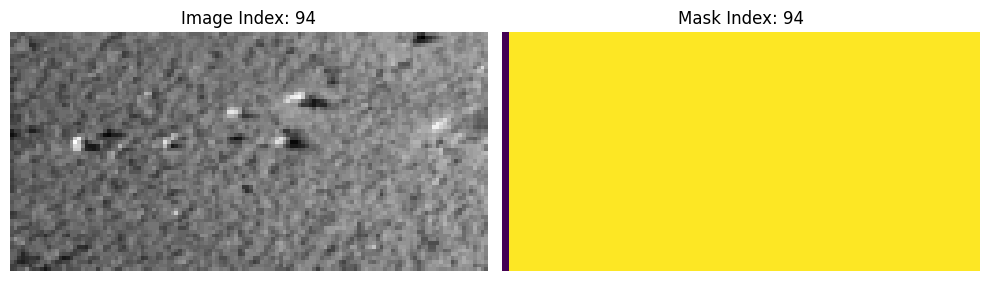

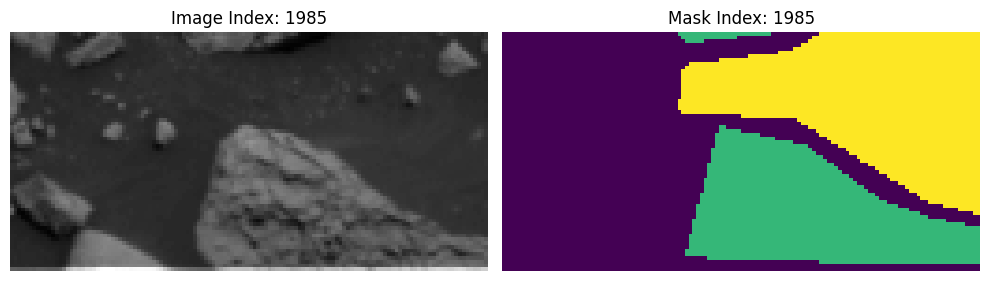

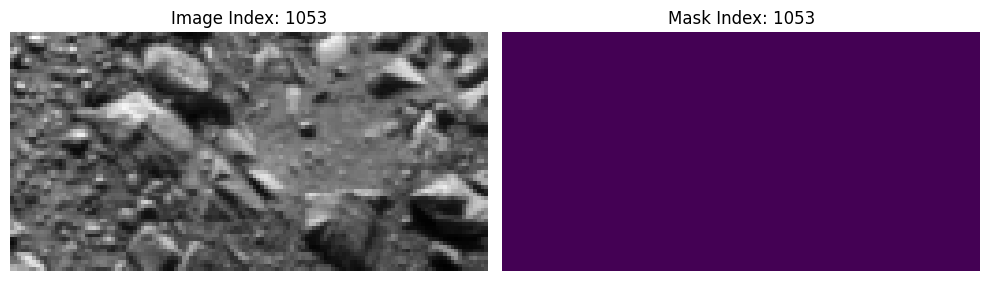

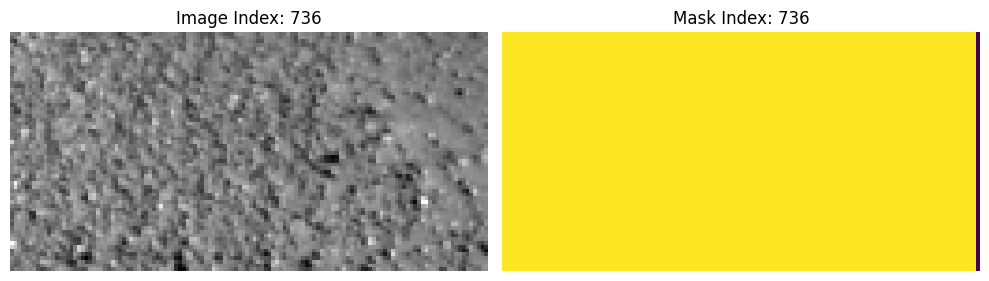

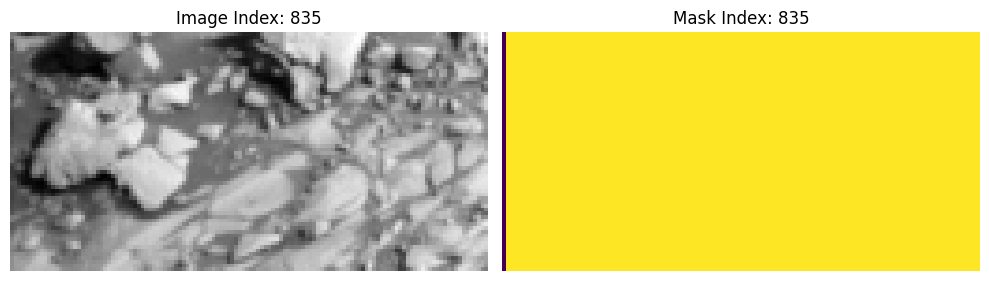

In [3]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

## LETS DO SOME AUGMENTATION!!

### rotation

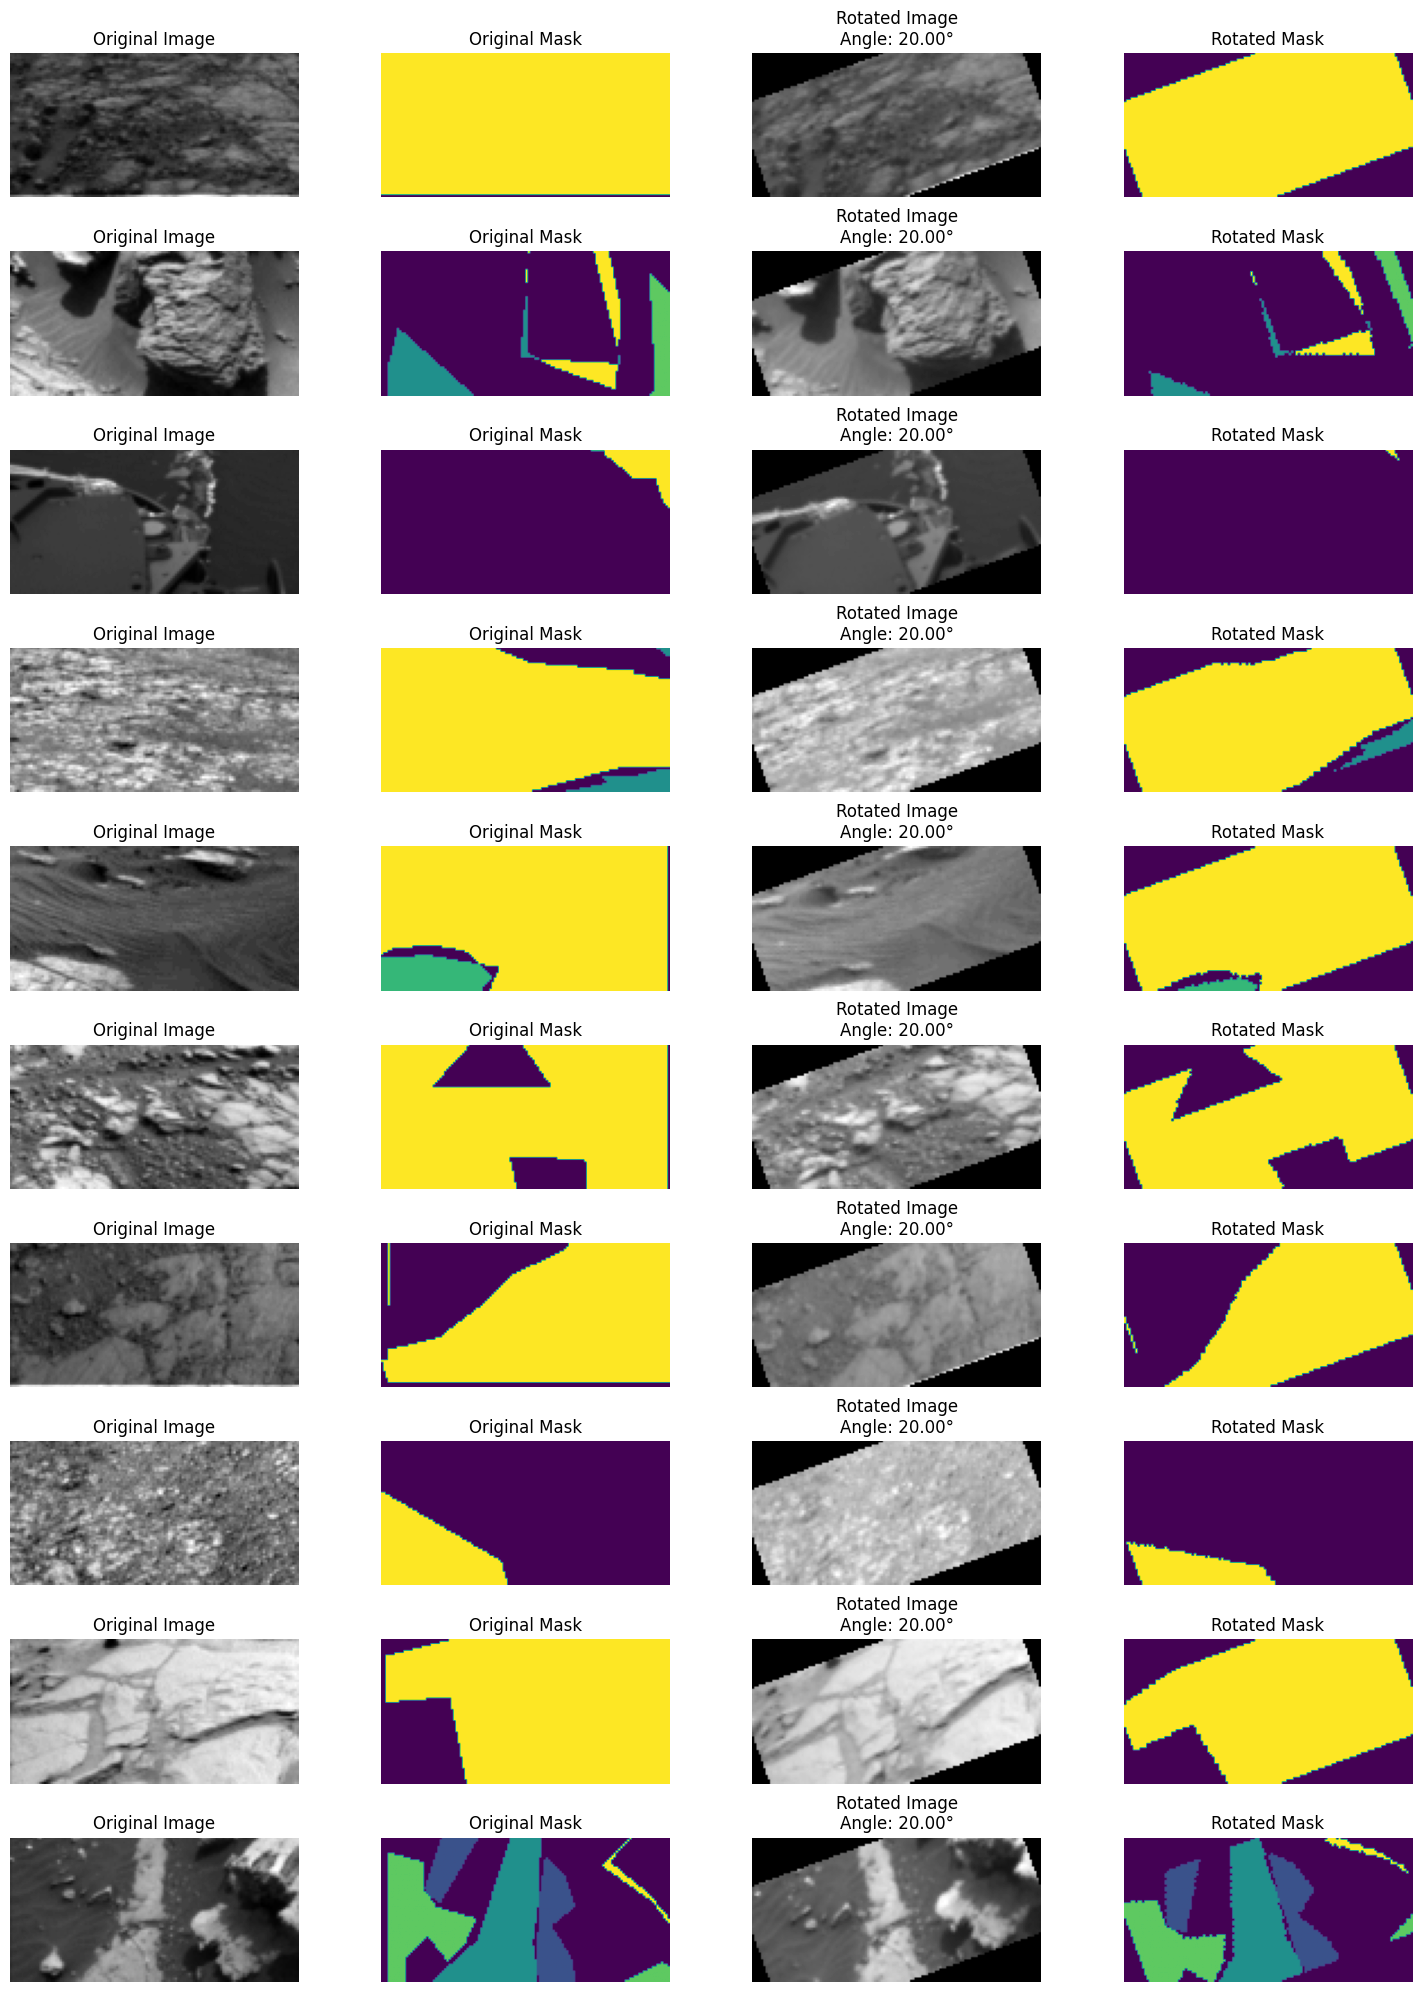

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# Define the rotation function using scipy
def rotate_image_and_mask(image, mask, angle):
    """
    Rotate a grayscale image and its corresponding mask by a given angle.
    """
    # Rotate the grayscale image (bilinear interpolation)
    rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

    # Rotate the mask (nearest-neighbor interpolation)
    rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

    return rotated_image, rotated_mask

# Randomly select 10 images
random_indices = np.random.choice(len(X_train), size=10, replace=False)
selected_images = X_train[random_indices]
selected_masks = y_train[random_indices]

# Apply random rotation and visualize
plt.figure(figsize=(15, 20))
for i, (image, mask) in enumerate(zip(selected_images, selected_masks)):
    # Generate a random angle for rotation
    angle = np.random.uniform(20, 20)  # Random angle between -30° and 30°

    # Rotate the image and mask
    rotated_image, rotated_mask = rotate_image_and_mask(image, mask, angle)

    # Plot original and rotated images/masks
    plt.subplot(10, 4, i * 4 + 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 2)
    plt.imshow(mask, cmap="viridis")
    plt.title("Original Mask")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 3)
    plt.imshow(rotated_image, cmap="gray")
    plt.title(f"Rotated Image\nAngle: {angle:.2f}°")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 4)
    plt.imshow(rotated_mask, cmap="viridis")
    plt.title("Rotated Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


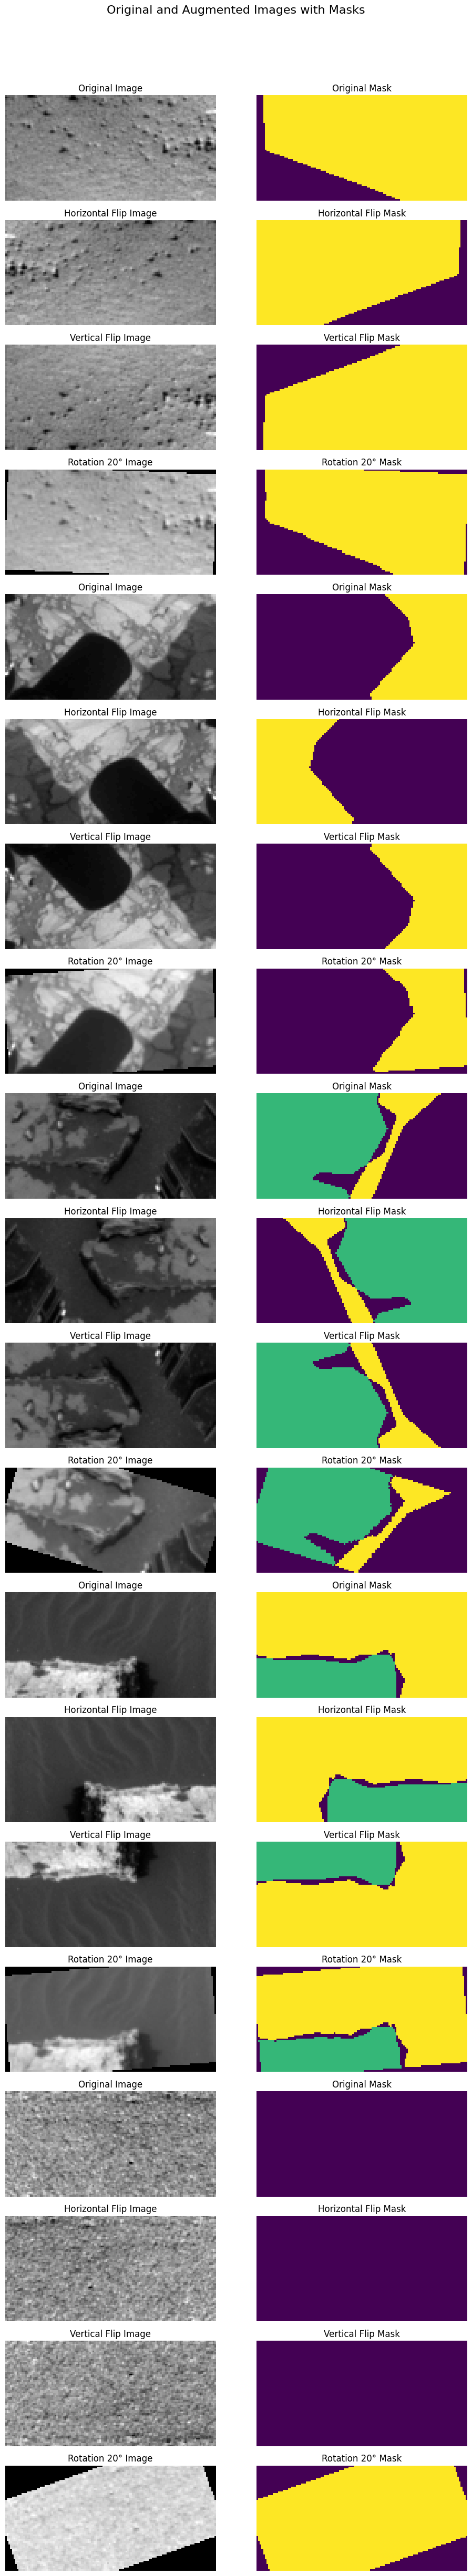

In [5]:
# Helper functions for applying augmentations
def augment_image_and_mask(image, mask, augment_type):
    if augment_type == "Horizontal Flip":
        return np.fliplr(image), np.fliplr(mask)
    elif augment_type == "Vertical Flip":
        return np.flipud(image), np.flipud(mask)
    elif augment_type == "Rotation 20°":
        angle = np.random.uniform(-20, 20)
        # Rotate the grayscale image (bilinear interpolation)
        rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

        # Rotate the mask (nearest-neighbor interpolation)
        rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

        return rotated_image, rotated_mask
    """elif augment_type == "Zoom (0.8-1.2)":
        zoom_factor = random.uniform(0.8, 1.2)
        zoom_image = np.clip(image * zoom_factor, 0, 255)
        return zoom_image, mask
    elif augment_type == "Shift (Width and Height)":
        shift_x, shift_y = random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1)
        return shift(image, [shift_x * image.shape[0], shift_y * image.shape[1]]), shift(mask, [shift_x * mask.shape[0], shift_y * mask.shape[1]], order=0)"""
    return image, mask

# Define augmentations
data_augmentations = {
    "Horizontal Flip": "Horizontal Flip",
    "Vertical Flip": "Vertical Flip",
    "Rotation 20°": "Rotation 20°",
    #"Zoom (0.8-1.2)": "Zoom (0.8-1.2)",
    #"Shift (Width and Height)": "Shift (Width and Height)",
}

# Visualize 5 random images and masks with augmentations
random_indices = np.random.choice(len(X_train), size=5, replace=False)
# Adjusting to display original image/mask with augmentations below each
fig, axes = plt.subplots(len(random_indices) * (1 + len(data_augmentations)), 2, figsize=(10, 50))
fig.suptitle("Original and Augmented Images with Masks", fontsize=16)

for idx, random_idx in enumerate(random_indices):
    original_image = X_train[random_idx]
    original_mask = y_train[random_idx]

    # Plot original image and mask
    row = idx * (1 + len(data_augmentations))  # Calculate starting row for each original image
    axes[row, 0].imshow(original_image, cmap='gray')
    axes[row, 0].set_title("Original Image")
    axes[row, 0].axis('off')

    axes[row, 1].imshow(original_mask)
    axes[row, 1].set_title("Original Mask")
    axes[row, 1].axis('off')

    # Apply augmentations and plot augmented images and masks
    for aug_idx, (augmentation_name, augment_type) in enumerate(data_augmentations.items()):
        augmented_image, augmented_mask = augment_image_and_mask(original_image, original_mask, augment_type)

        axes[row + aug_idx + 1, 0].imshow(augmented_image , cmap='gray' )
        axes[row + aug_idx + 1, 0].set_title(f"{augmentation_name} Image")
        axes[row + aug_idx + 1, 0].axis('off')

        axes[row + aug_idx + 1, 1].imshow(augmented_mask)
        axes[row + aug_idx + 1, 1].set_title(f"{augmentation_name} Mask")
        axes[row + aug_idx + 1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [6]:
import os
import matplotlib.pyplot as plt

# Directory where augmented files are stored
output_dir = "augmented_data"
os.makedirs(output_dir, exist_ok=True)

# Re-save augmented datasets to the directory with structured filenames
for augmentation_name, augment_type in data_augmentations.items():
    augmented_images = []
    augmented_masks = []

    for image, mask in zip(X_train, y_train):
        aug_image, aug_mask = augment_image_and_mask(image, mask, augment_type)
        augmented_images.append(aug_image)
        augmented_masks.append(aug_mask)

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    # Save to npz file
    output_path = os.path.join(output_dir, f"{augmentation_name.replace(' ', '_').lower()}.npz")
    np.savez_compressed(output_path, augmented_images=augmented_images, augmented_masks=augmented_masks)


File: vertical_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


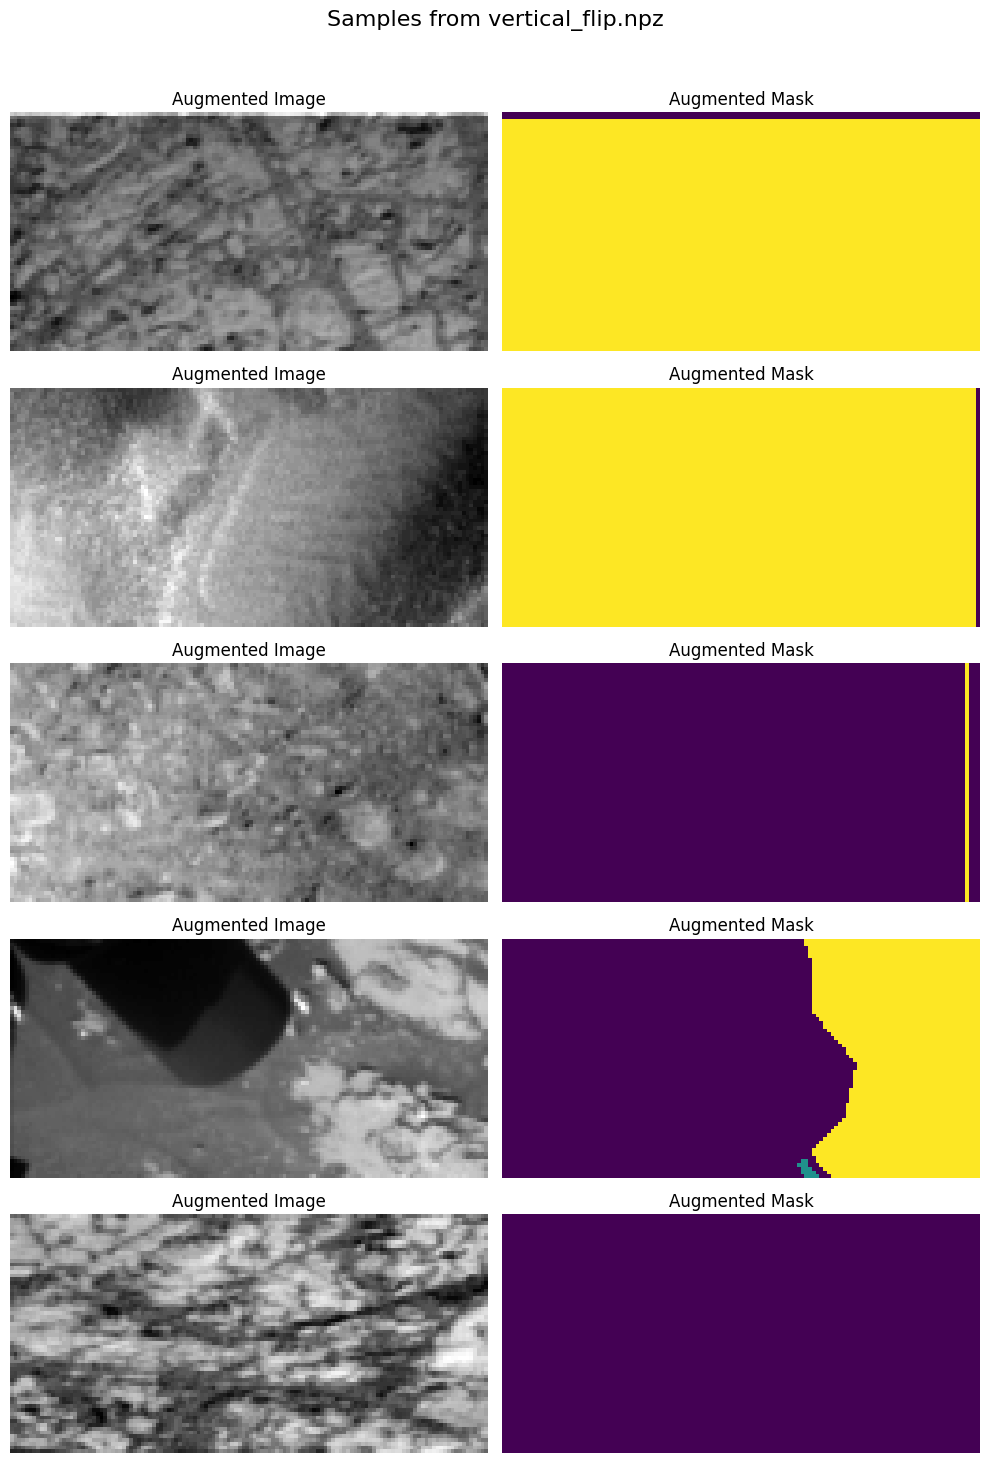

File: horizontal_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


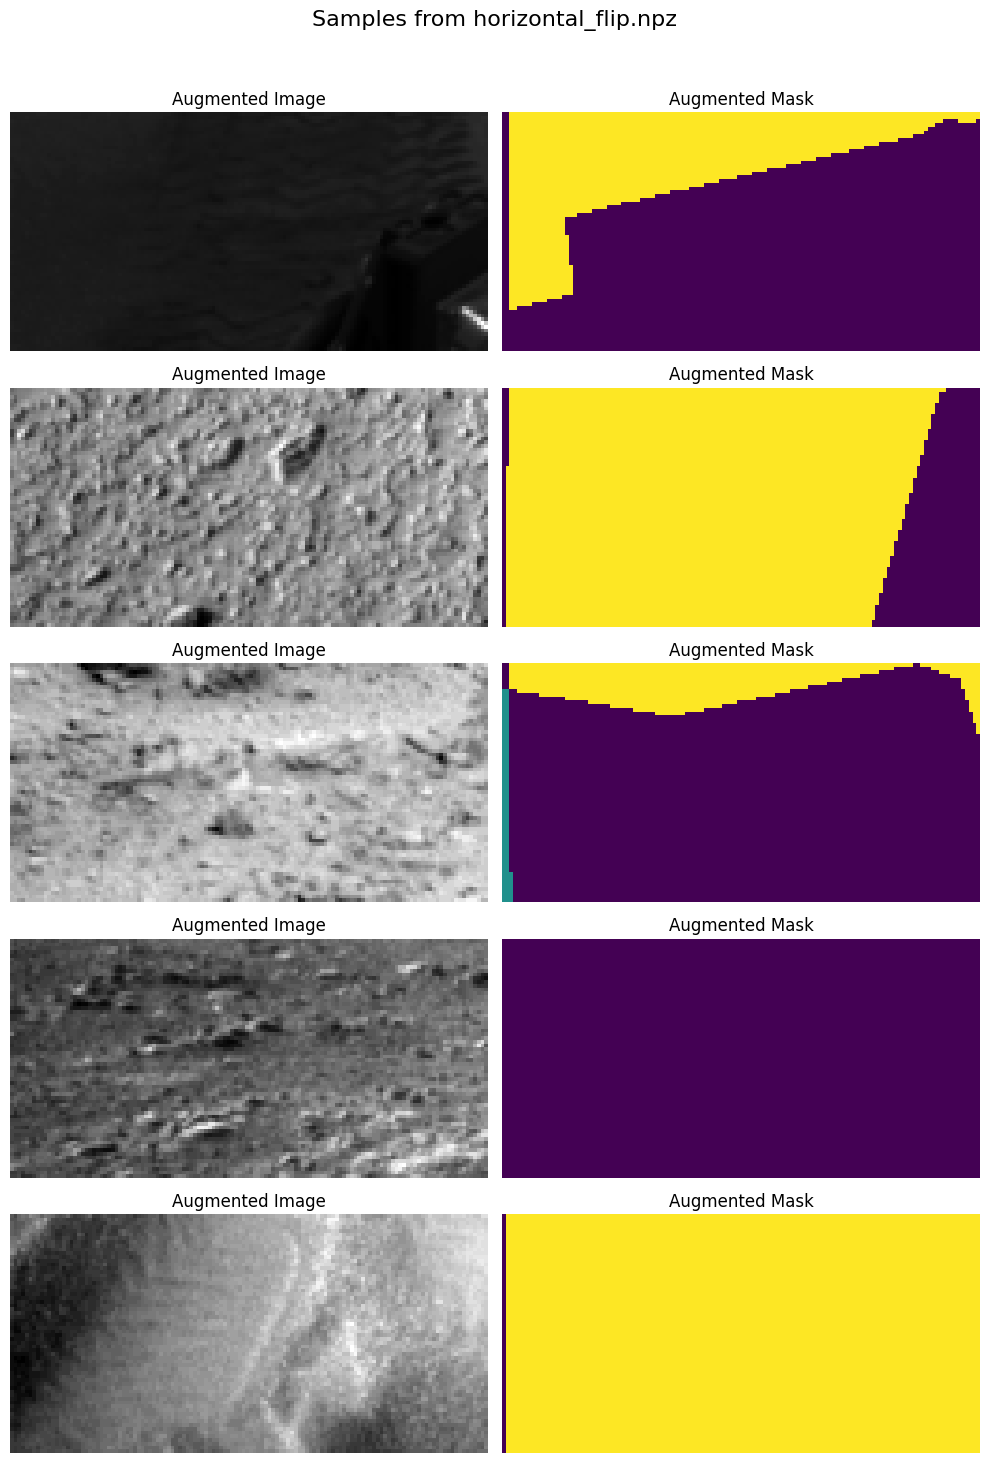

File: rotation_20°.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


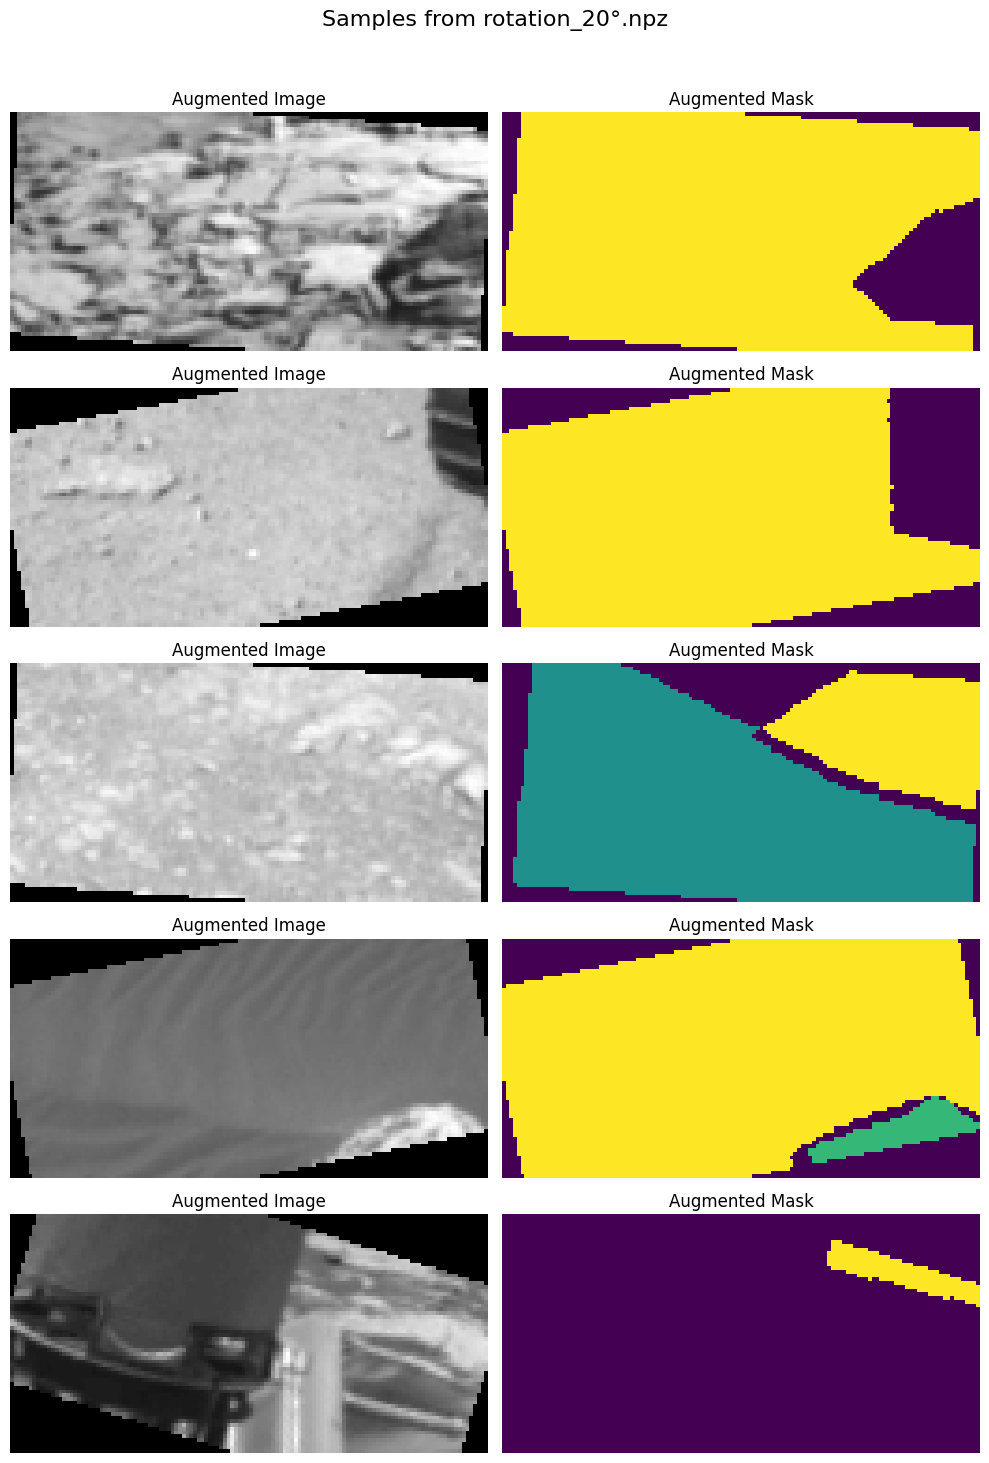

In [7]:
# Read the saved files and display details
output_dir="/kaggle/working/augmented_data"
for file_name in os.listdir(output_dir):
    if file_name.endswith(".npz"):
        file_path = os.path.join(output_dir, file_name)
        data = np.load(file_path)

        # Display keys and their shapes
        print(f"File: {file_name}")
        for key in data.keys():
            print(f"  Key: {key}, Shape: {data[key].shape}")

        # Plot 5 random images and masks
        fig, axes = plt.subplots(5, 2, figsize=(10, 15))
        fig.suptitle(f"Samples from {file_name}", fontsize=16)
        for i in range(5):
            random_idx = np.random.randint(data["augmented_images"].shape[0])
            axes[i, 0].imshow(data["augmented_images"][random_idx], cmap="gray")
            axes[i, 0].set_title("Augmented Image")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(data["augmented_masks"][random_idx])
            axes[i, 1].set_title("Augmented Mask")
            axes[i, 1].axis("off")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

## 🛠️ Train and Save the Model

In [8]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/horizontal_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (4008, 64, 128)
New y_train shape: (4008, 64, 128)


In [9]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/vertical_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (6012, 64, 128)
New y_train shape: (6012, 64, 128)


In [10]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/rotation_20°.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (8016, 64, 128)
New y_train shape: (8016, 64, 128)


In [11]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [12]:
X_val = X_val[..., np.newaxis] / 255.0

In [13]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (8016, 64, 128, 1)
X_val shape: (501, 64, 128, 1)
y_train shape: (8016, 64, 128)


In [14]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis")
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis")
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

## Adding advanced tecnics

In [15]:
# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove any singleton dimensions
y_train = np.squeeze(y_train)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

if y_train.ndim == 3:  # Ensure y_train has the correct shape
    y_train = y_train[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

Shape of X_train after reshaping: (8016, 64, 128, 1)
Shape of y_train after reshaping: (8016, 64, 128, 1)


In [16]:
# Ensure the input shape for both images and masks is correct
X_val = np.squeeze(X_val)  # Remove any singleton dimensions
y_val= np.squeeze(y_val)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_val.ndim == 3:  # If missing the channel dimension, add it
    X_val = X_val[..., np.newaxis]

if y_val.ndim == 3:  # Ensure y_train has the correct shape
    y_val = y_val[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_val.shape}")
print(f"Shape of y_train after reshaping: {y_val.shape}")

Shape of X_train after reshaping: (501, 64, 128, 1)
Shape of y_train after reshaping: (501, 64, 128, 1)


In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove singleton dimensions
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

y_train = np.squeeze(y_train)  # Ensure that y_train has the correct shape

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

# Data Augmentation for Images and Masks
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
)

# Masks should only be flipped or translated without interpolation
mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Ensure y_train has the correct shape for augmentation
y_train = np.expand_dims(y_train, axis=-1)  # Add channel dimension to masks

# Fit augmentations to the data
image_datagen.fit(X_train)
mask_datagen.fit(y_train)

# Create the generators
image_generator = image_datagen.flow(X_train, batch_size=32, seed=42)
mask_generator = mask_datagen.flow(y_train, batch_size=32, seed=42)

train_generator = zip(image_generator, mask_generator)

# Weighted Loss Function for Class Imbalance
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Remove the extra dimension from y_true using tf.squeeze
        y_true = tf.squeeze(y_true, axis=-1)

        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(weights))
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        return -tf.reduce_sum(y_true * tf.math.log(y_pred) * weights, axis=-1)

    return loss

# Convert y_train to integers for class count
y_train_int = y_train.astype(np.int32)

# Calculate class weights based on pixel proportions
class_pixel_counts = np.bincount(y_train_int.flatten(), minlength=num_classes)  # Count pixels for each class
total_pixels = np.sum(class_pixel_counts)  # Total number of pixels
class_weights = total_pixels / (class_pixel_counts + 1e-6)  # Inverse frequency
class_weights /= np.sum(class_weights)  # Normalize to sum to 1

print(f"Class pixel counts: {class_pixel_counts}")
print(f"Calculated class weights: {class_weights}")

# Use the calculated weights in the loss function
loss = weighted_categorical_crossentropy(class_weights)

# Define the U-Net Model
def unet_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Decoder
    u1 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c2)
    u1 = tf.keras.layers.concatenate([u1, c1])
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u1)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c3)

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="softmax")(c3)
    return tf.keras.Model(inputs, outputs)

# Initialize the model
input_shape = X_train.shape[1:]
model = unet_model(input_shape, num_classes)
model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model.summary()

# Updated EarlyStopping with min_delta to ignore minimal improvements
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor loss instead of validation loss
    patience=15,
    restore_best_weights=True,
    min_delta=1e-4  # Minimum change to qualify as an improvement
)


model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",  # Monitor loss instead of validation loss
    save_best_only=True,
    mode="min",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor loss instead of validation loss
    factor=0.5,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-6
)

# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_val, y_val, num_images=2)




Shape of X_train after reshaping: (8016, 64, 128, 1)
Shape of y_train after reshaping: (8016, 64, 128)
Class pixel counts: [17126398 21591591 15320874 11545468    82741]
Calculated class weights: [0.00473076 0.00375243 0.00528827 0.00701755 0.97921099]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 128,   │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 128,   │     32,832 │ conv2d_3[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 128,   │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 128,   │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 128,   │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 128,   │        325 │ conv2d_5[0][0]    │
│                     │ 5)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 402,885 (1.54 MB)

 Trainable params: 402,885 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 128,   │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 128,   │     36,928 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 128,   │        128 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 128,   │          0 │ conv2d_8[0][0],   │
│                     │ 64)               │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 64,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 64,    │    147,584 │ conv2d_10[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 64,    │      8,320 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 64,    │          0 │ conv2d_11[0][0],  │
│                     │ 128)              │            │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 32,    │          0 │ add_1[0][0]       │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 32,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 32,    │    590,080 │ conv2d_13[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 32,    │     33,024 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 16, 32,    │          0 │ conv2d_14[0][0],  │
│                     │ 256)              │            │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 8, 16,     │          0 │ add_2[0][0]       │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 8, 16,     │  1,180,160 │ max_pooling2d_4[

 Total params: 8,041,989 (30.68 MB)

 Trainable params: 8,041,989 (30.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


I0000 00:00:1733259331.894256      93 service.cc:145] XLA service 0x7cf908026b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733259331.894310      93 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733259331.894314      93 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1733259332.482723      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1733259365.584416      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.3438 - loss: 1.3768 - mean_io_u: 0.1111

W0000 00:00:1733259417.875068      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.3440 - loss: 1.3764 - mean_io_u: 0.1113

W0000 00:00:1733259443.046086      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733259444.590715      92 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_loss improved from inf to 1.20599, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


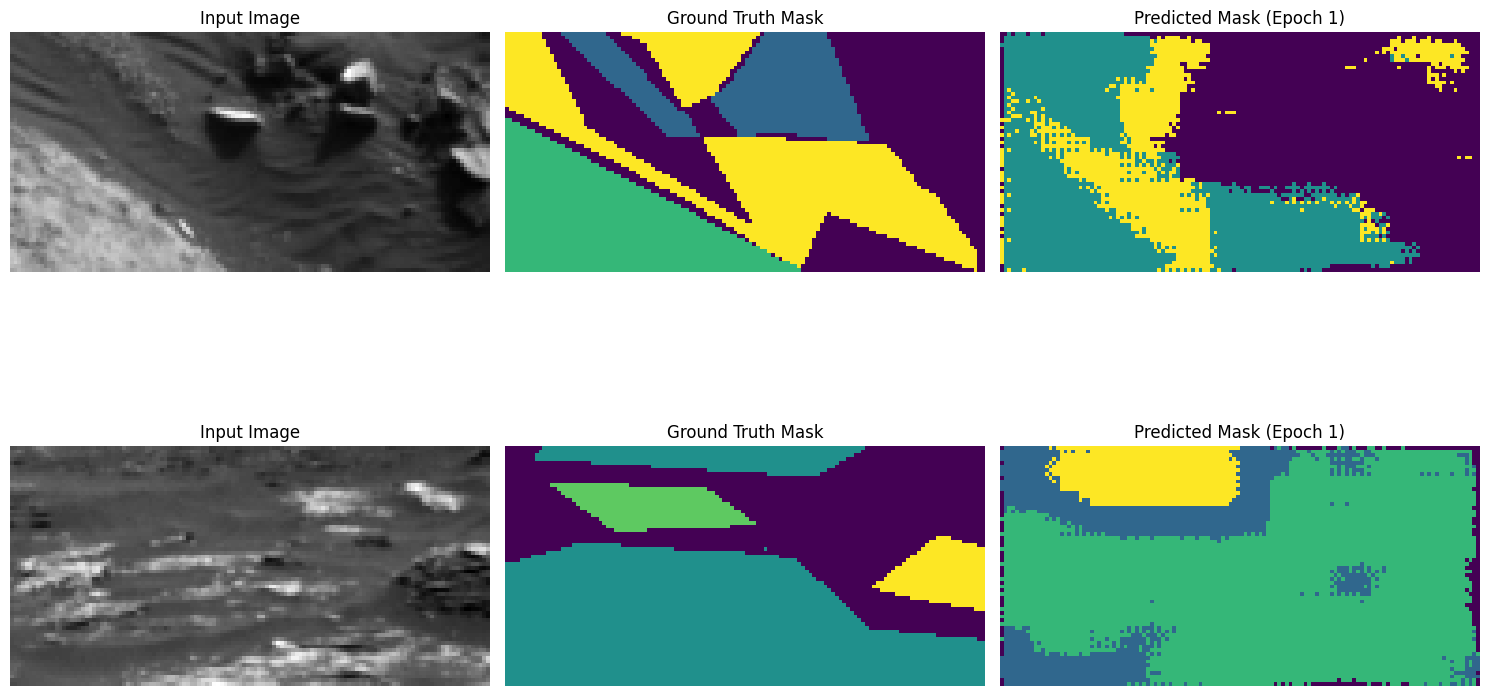

251/251 ━━━━━━━━━━━━━━━━━━━━ 131s 364ms/step - accuracy: 0.3442 - loss: 1.3760 - mean_io_u: 0.1114 - val_accuracy: 0.4521 - val_loss: 1.2060 - val_mean_io_u: 0.2281 - learning_rate: 1.0000e-04
Epoch 2/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4930 - loss: 1.1090 - mean_io_u: 0.2302
Epoch 2: val_loss improved from 1.20599 to 1.04301, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


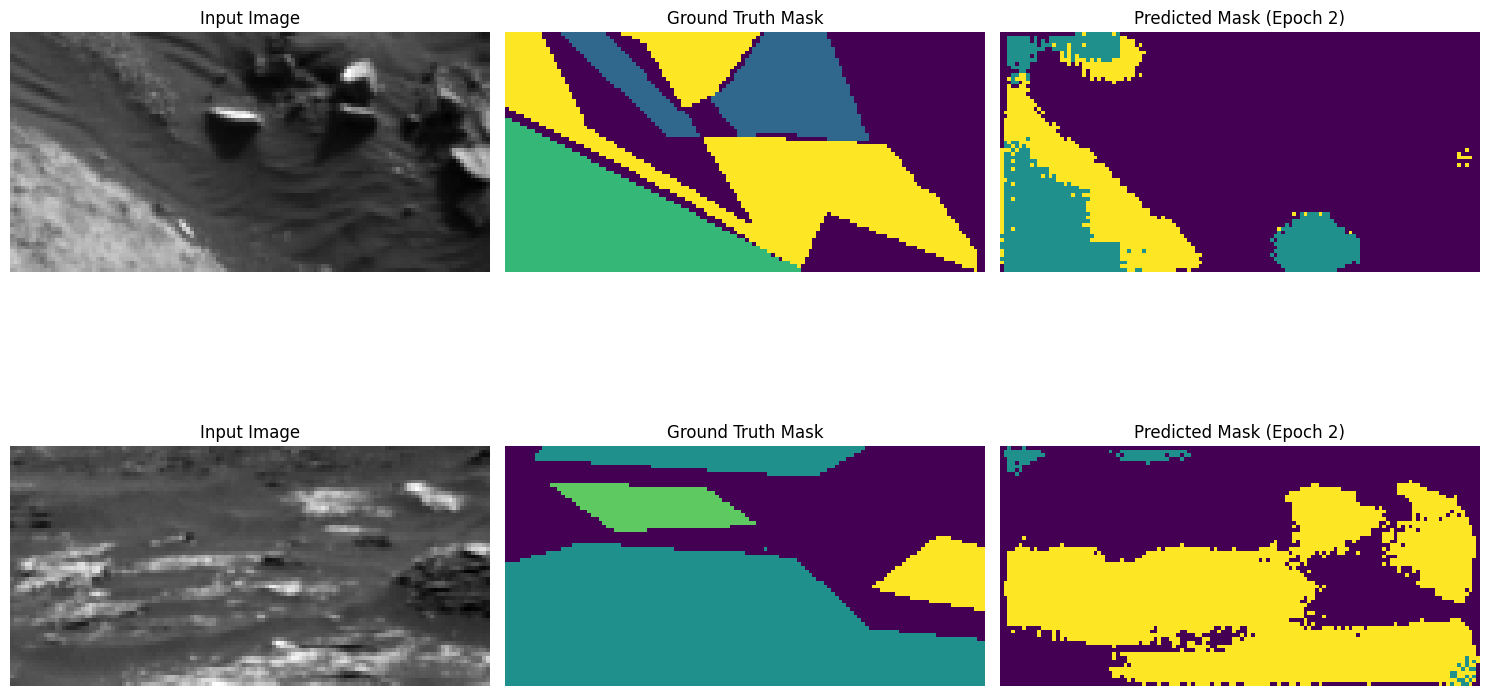

251/251 ━━━━━━━━━━━━━━━━━━━━ 54s 216ms/step - accuracy: 0.4931 - loss: 1.1088 - mean_io_u: 0.2302 - val_accuracy: 0.5695 - val_loss: 1.0430 - val_mean_io_u: 0.2797 - learning_rate: 1.0000e-04
Epoch 3/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5554 - loss: 1.0103 - mean_io_u: 0.2647
Epoch 3: val_loss improved from 1.04301 to 0.92924, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


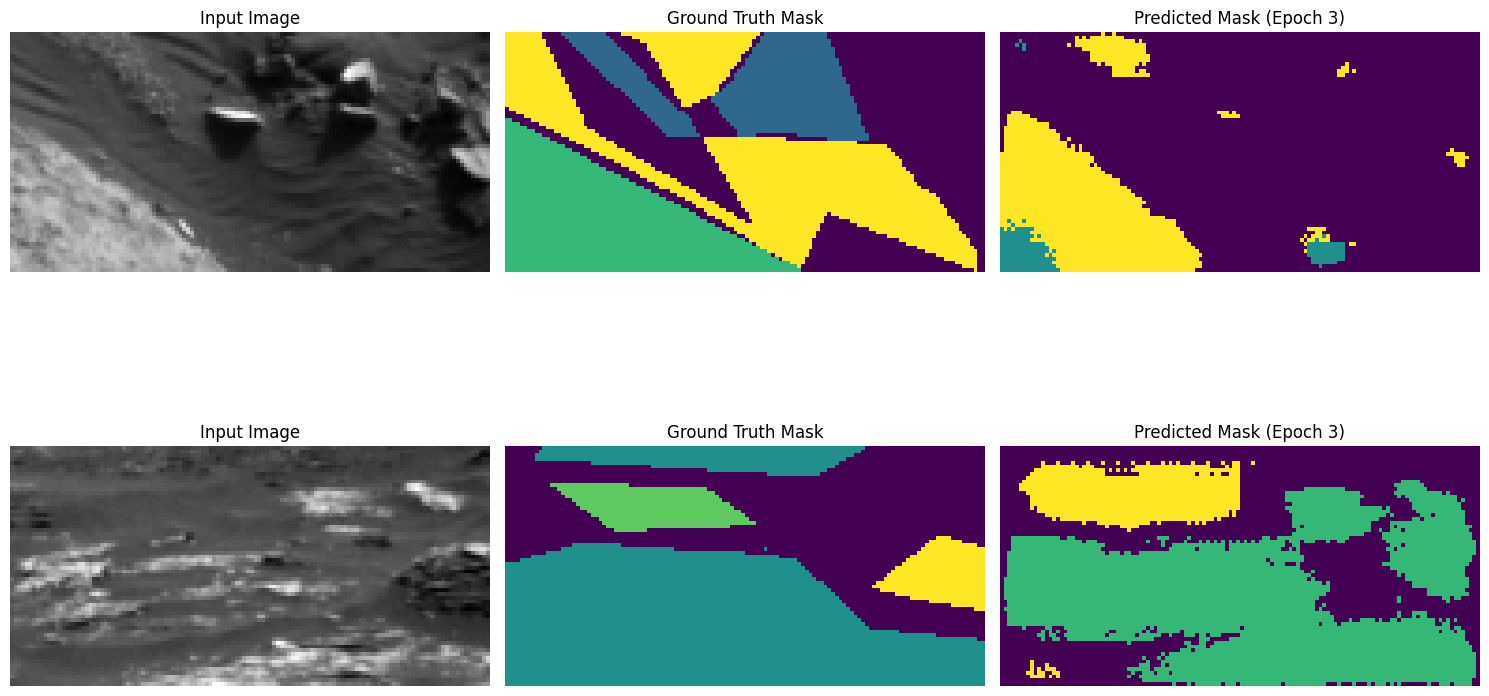

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.5555 - loss: 1.0102 - mean_io_u: 0.2648 - val_accuracy: 0.6376 - val_loss: 0.9292 - val_mean_io_u: 0.3567 - learning_rate: 1.0000e-04
Epoch 4/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6191 - loss: 0.9308 - mean_io_u: 0.3239
Epoch 4: val_loss improved from 0.92924 to 0.90150, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


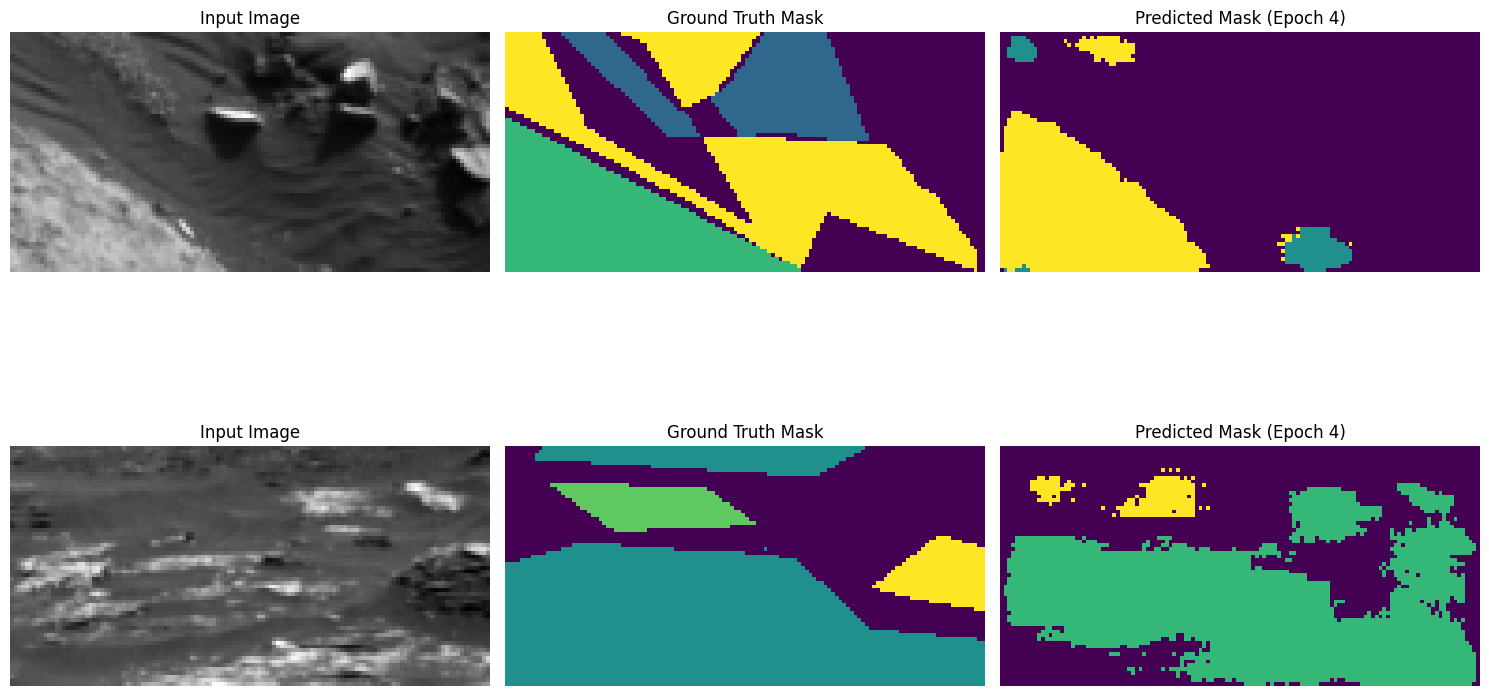

251/251 ━━━━━━━━━━━━━━━━━━━━ 54s 213ms/step - accuracy: 0.6191 - loss: 0.9307 - mean_io_u: 0.3240 - val_accuracy: 0.6577 - val_loss: 0.9015 - val_mean_io_u: 0.3648 - learning_rate: 1.0000e-04
Epoch 5/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6561 - loss: 0.8656 - mean_io_u: 0.3564
Epoch 5: val_loss improved from 0.90150 to 0.87320, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


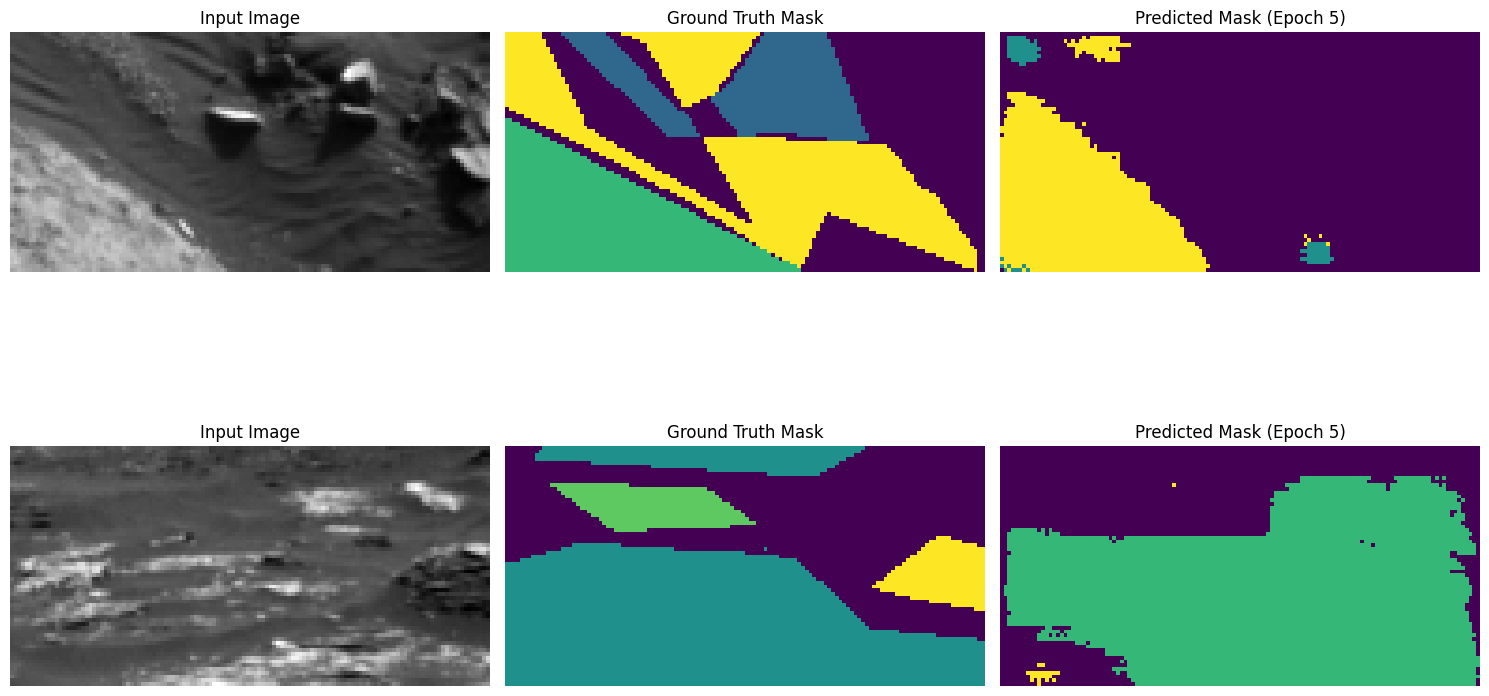

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.6561 - loss: 0.8655 - mean_io_u: 0.3564 - val_accuracy: 0.6705 - val_loss: 0.8732 - val_mean_io_u: 0.3711 - learning_rate: 1.0000e-04
Epoch 6/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6758 - loss: 0.8326 - mean_io_u: 0.3741
Epoch 6: val_loss improved from 0.87320 to 0.84631, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


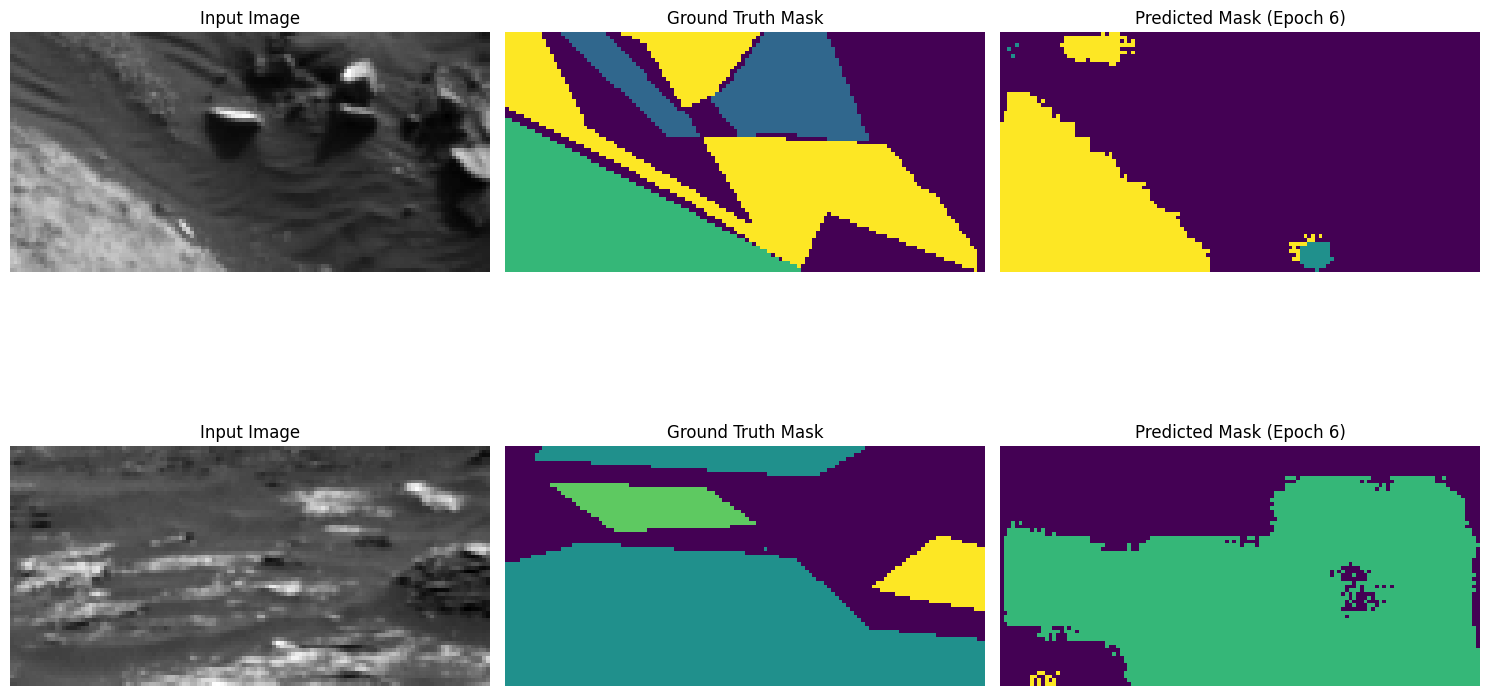

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.6758 - loss: 0.8326 - mean_io_u: 0.3742 - val_accuracy: 0.6766 - val_loss: 0.8463 - val_mean_io_u: 0.3773 - learning_rate: 1.0000e-04
Epoch 7/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6871 - loss: 0.8041 - mean_io_u: 0.3836
Epoch 7: val_loss improved from 0.84631 to 0.82368, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


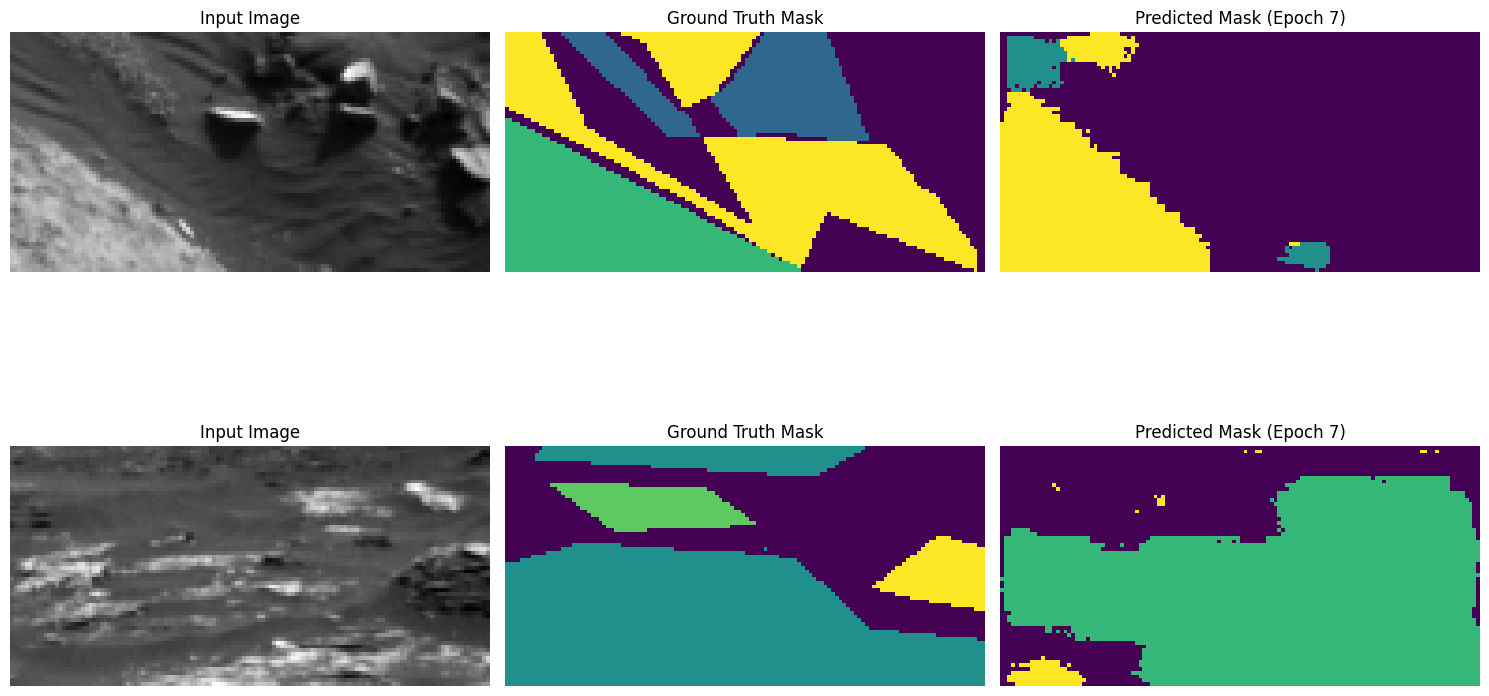

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.6871 - loss: 0.8040 - mean_io_u: 0.3836 - val_accuracy: 0.6827 - val_loss: 0.8237 - val_mean_io_u: 0.3910 - learning_rate: 1.0000e-04
Epoch 8/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7007 - loss: 0.7701 - mean_io_u: 0.3963
Epoch 8: val_loss improved from 0.82368 to 0.79807, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


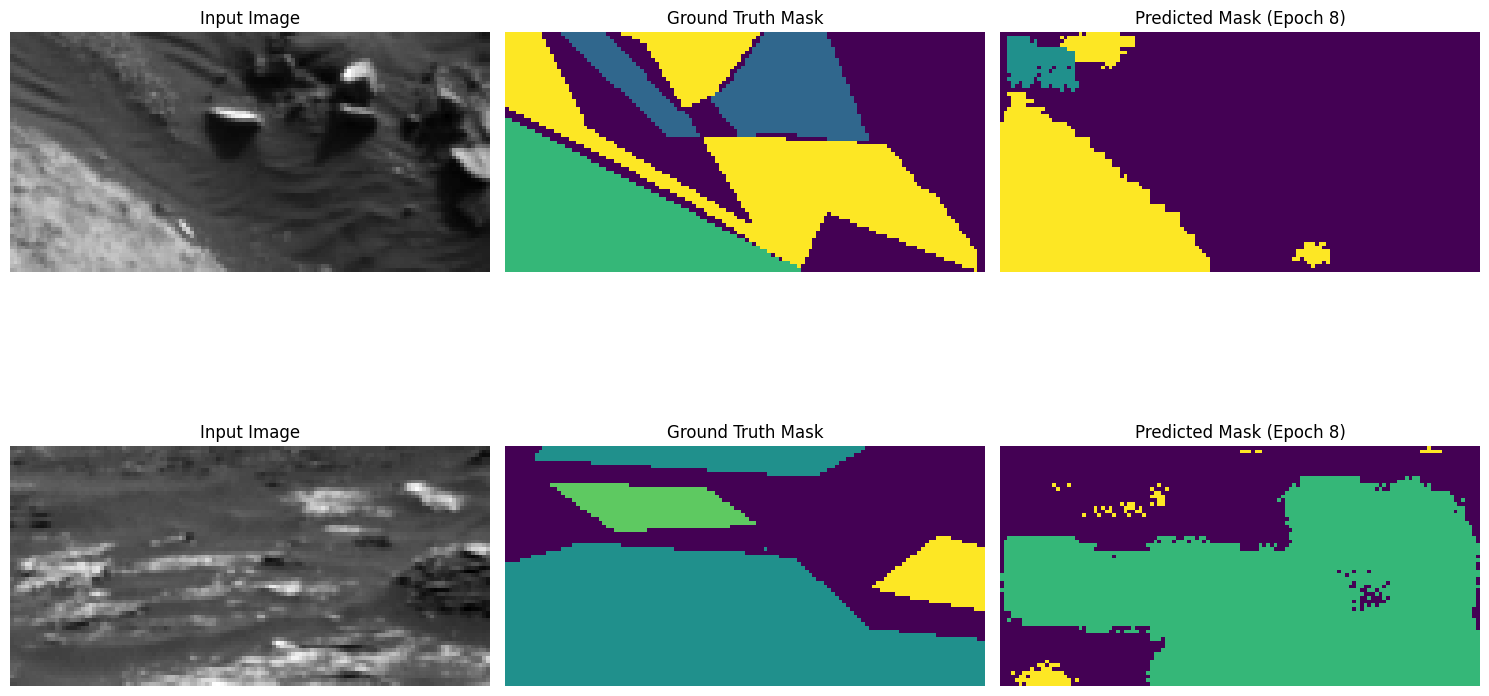

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.7008 - loss: 0.7701 - mean_io_u: 0.3964 - val_accuracy: 0.6953 - val_loss: 0.7981 - val_mean_io_u: 0.3988 - learning_rate: 1.0000e-04
Epoch 9/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7141 - loss: 0.7409 - mean_io_u: 0.4090
Epoch 9: val_loss improved from 0.79807 to 0.74643, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


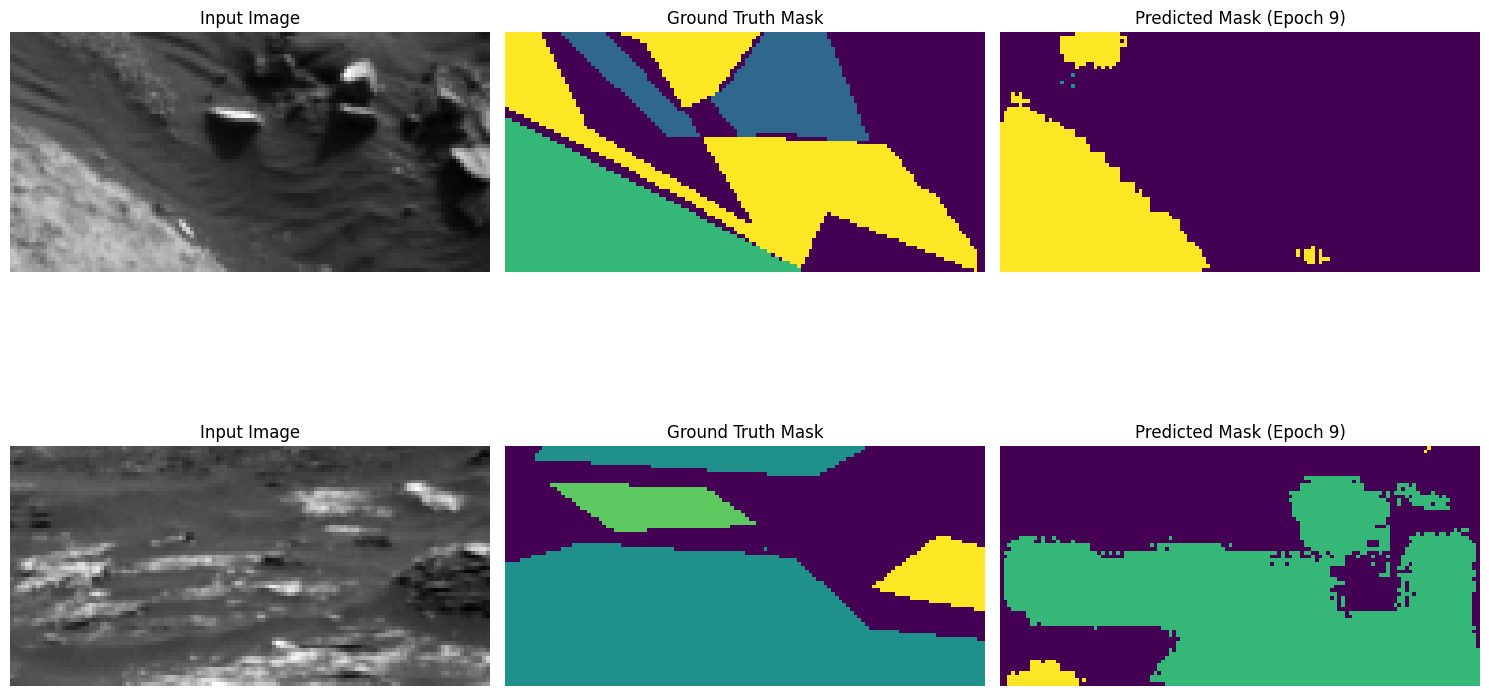

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 212ms/step - accuracy: 0.7141 - loss: 0.7408 - mean_io_u: 0.4090 - val_accuracy: 0.7161 - val_loss: 0.7464 - val_mean_io_u: 0.4165 - learning_rate: 1.0000e-04
Epoch 10/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7248 - loss: 0.7155 - mean_io_u: 0.4189
Epoch 10: val_loss improved from 0.74643 to 0.73264, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


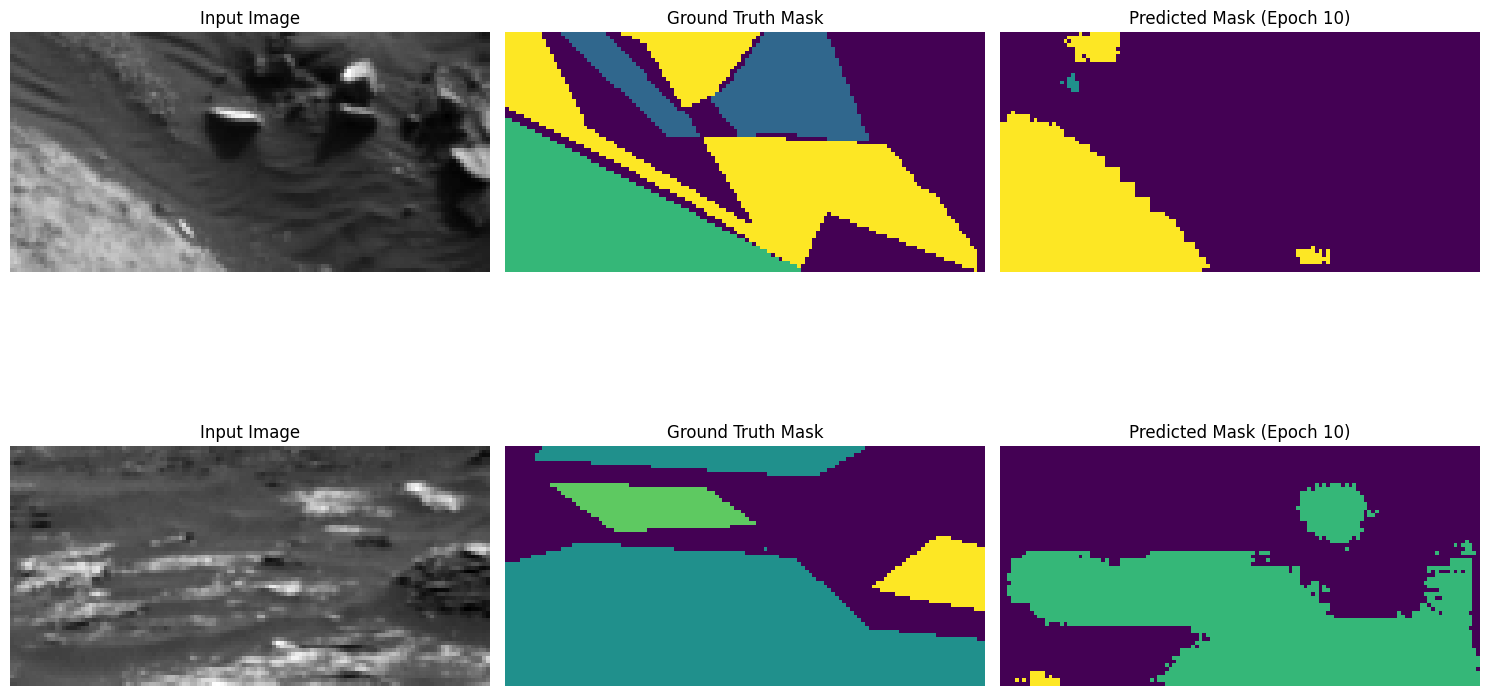

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.7249 - loss: 0.7155 - mean_io_u: 0.4189 - val_accuracy: 0.7195 - val_loss: 0.7326 - val_mean_io_u: 0.4144 - learning_rate: 1.0000e-04
Epoch 11/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7339 - loss: 0.6898 - mean_io_u: 0.4273
Epoch 11: val_loss improved from 0.73264 to 0.70610, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


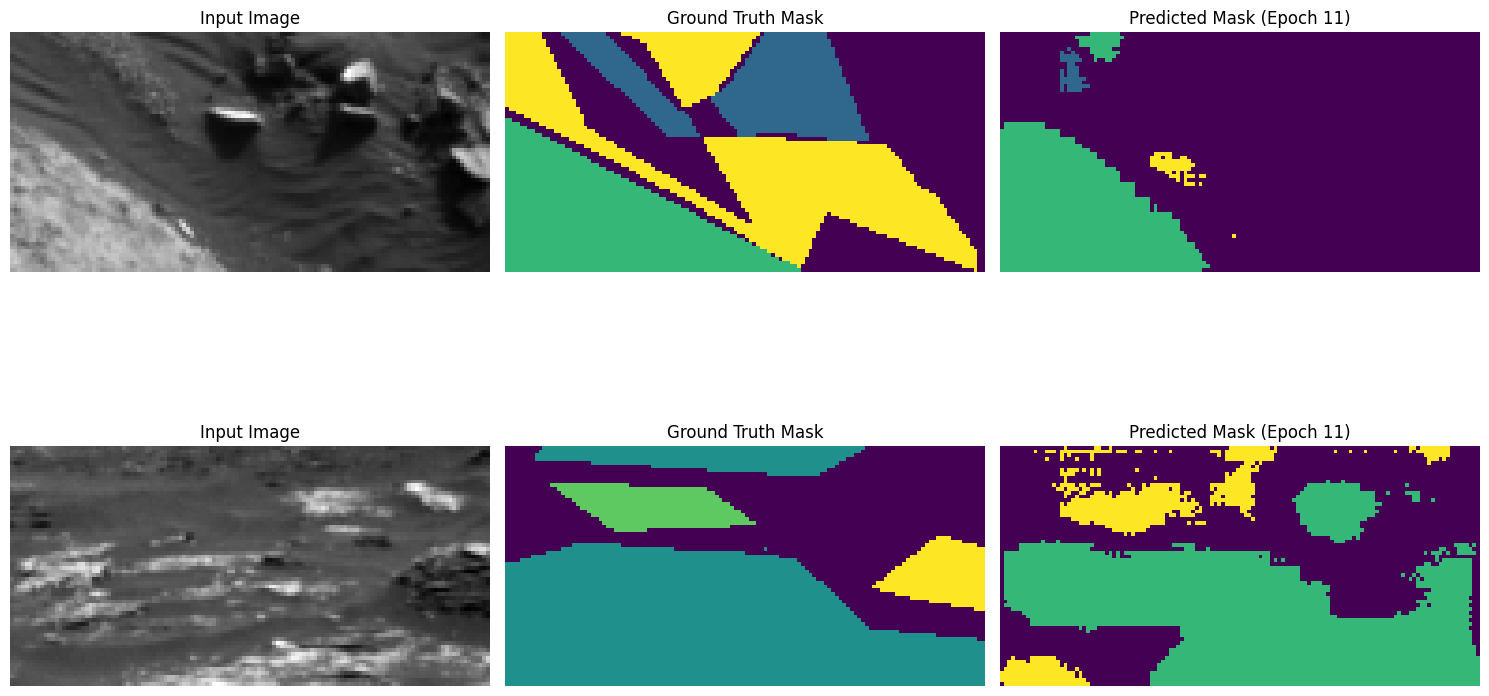

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.7339 - loss: 0.6898 - mean_io_u: 0.4273 - val_accuracy: 0.7315 - val_loss: 0.7061 - val_mean_io_u: 0.4341 - learning_rate: 1.0000e-04
Epoch 12/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7412 - loss: 0.6676 - mean_io_u: 0.4346
Epoch 12: val_loss did not improve from 0.70610
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


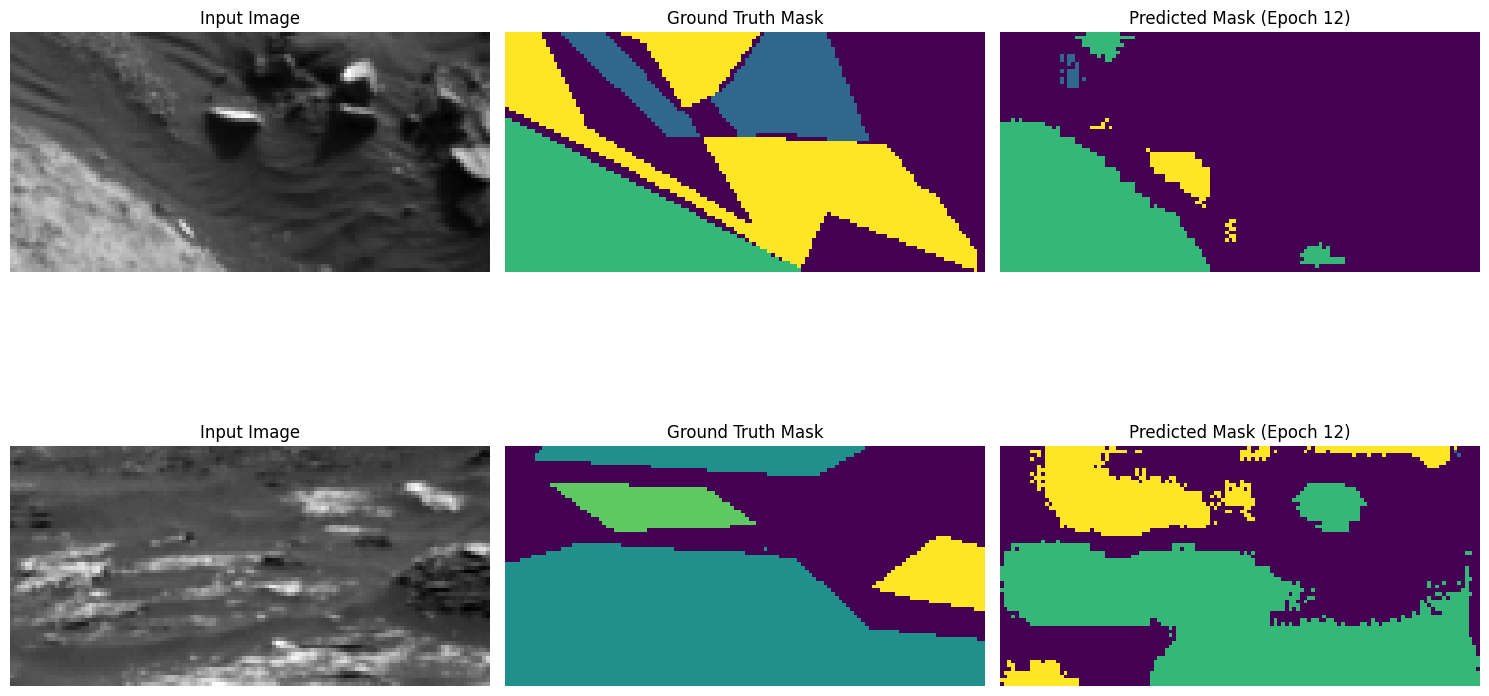

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 209ms/step - accuracy: 0.7412 - loss: 0.6676 - mean_io_u: 0.4346 - val_accuracy: 0.7316 - val_loss: 0.7112 - val_mean_io_u: 0.4348 - learning_rate: 1.0000e-04
Epoch 13/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7489 - loss: 0.6487 - mean_io_u: 0.4416
Epoch 13: val_loss improved from 0.70610 to 0.68676, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


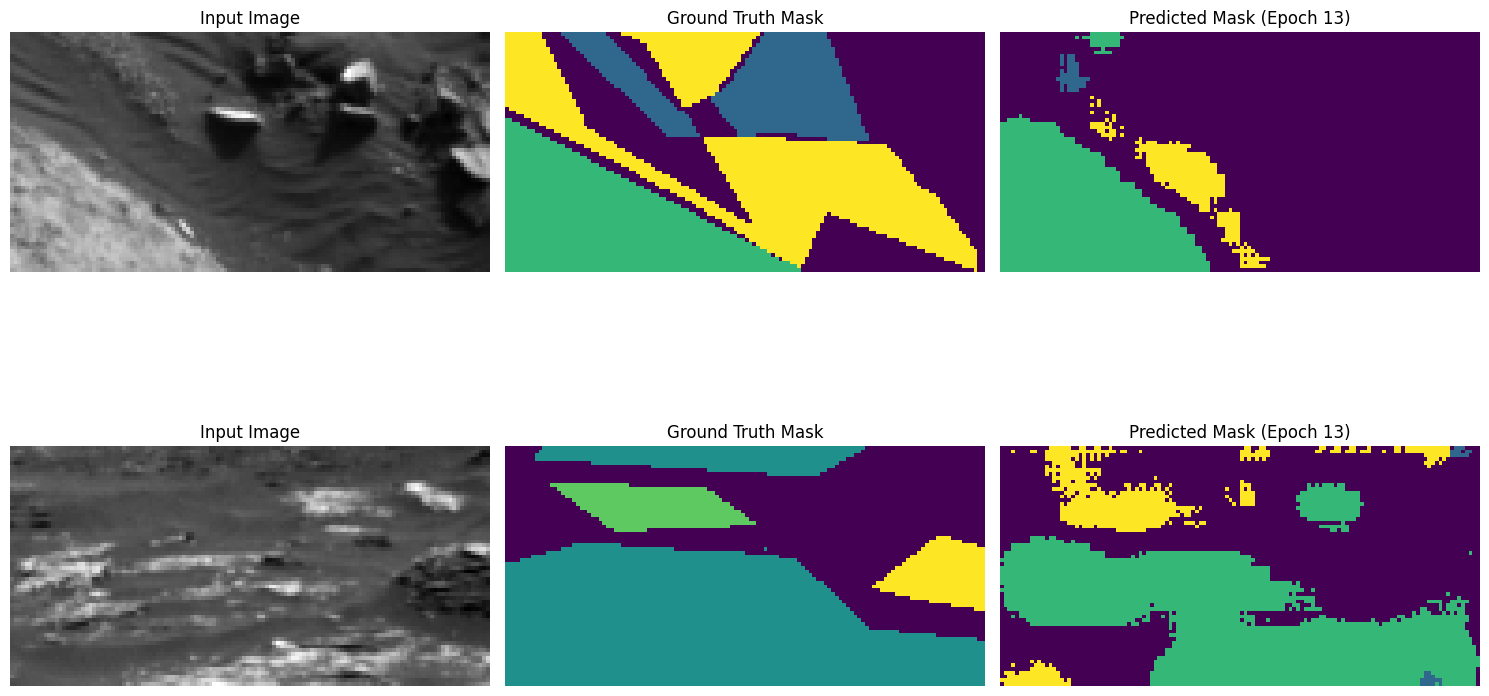

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.7489 - loss: 0.6487 - mean_io_u: 0.4416 - val_accuracy: 0.7412 - val_loss: 0.6868 - val_mean_io_u: 0.4409 - learning_rate: 1.0000e-04
Epoch 14/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7549 - loss: 0.6340 - mean_io_u: 0.4485
Epoch 14: val_loss did not improve from 0.68676
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


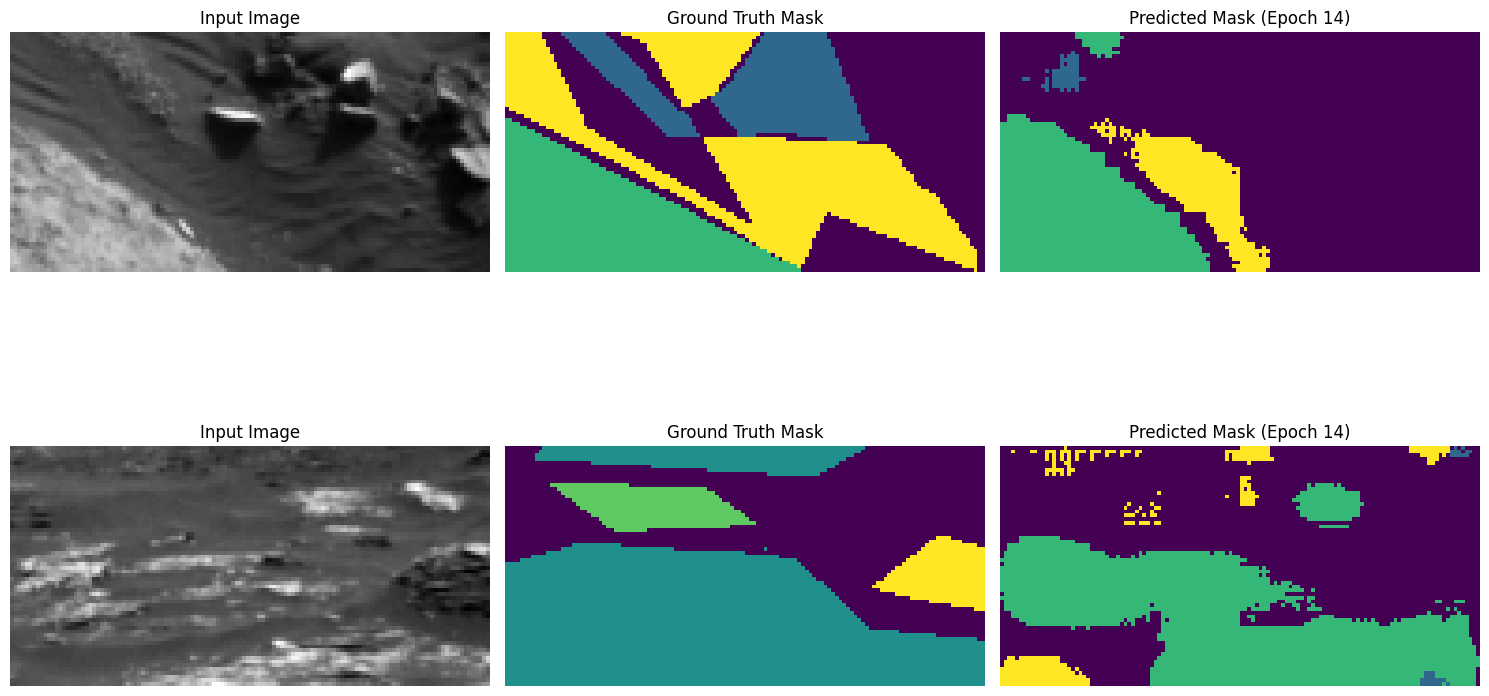

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 209ms/step - accuracy: 0.7549 - loss: 0.6339 - mean_io_u: 0.4485 - val_accuracy: 0.7395 - val_loss: 0.6987 - val_mean_io_u: 0.4355 - learning_rate: 1.0000e-04
Epoch 15/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7619 - loss: 0.6163 - mean_io_u: 0.4558
Epoch 15: val_loss did not improve from 0.68676
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


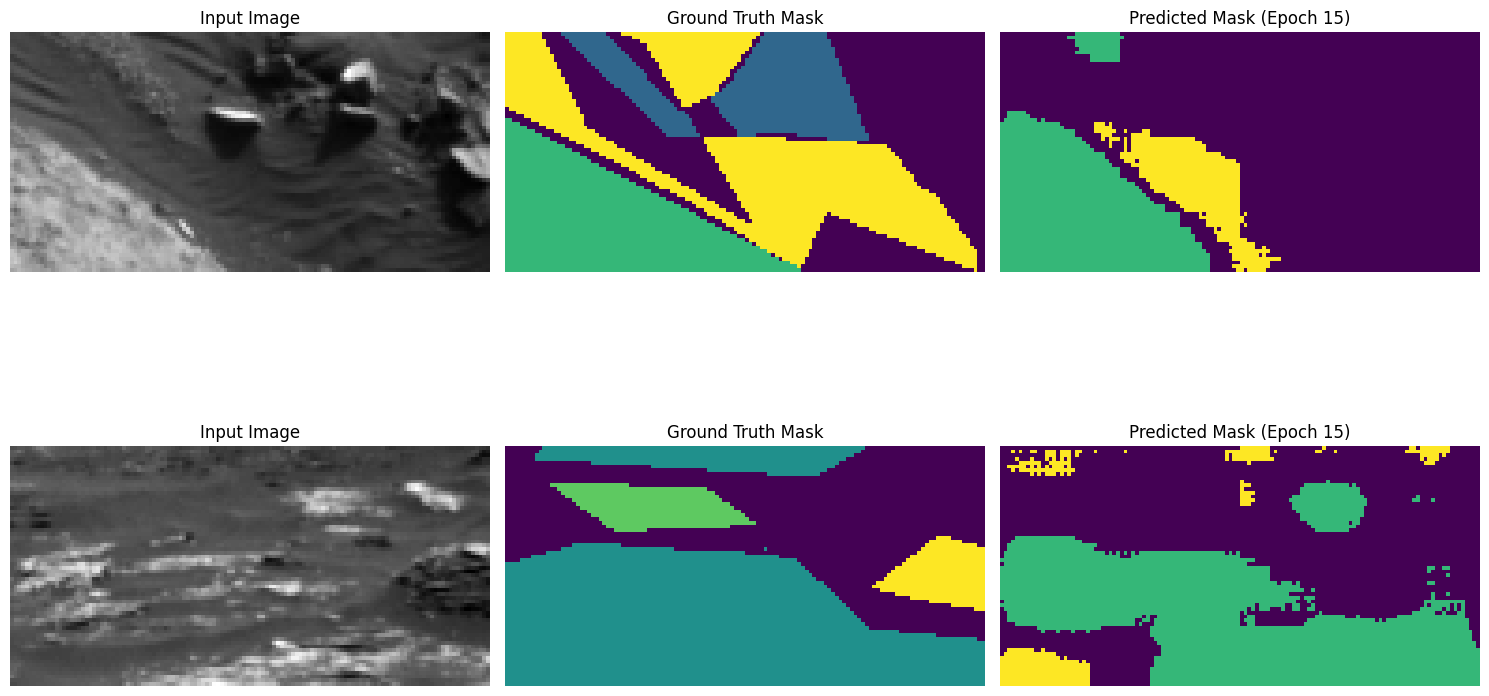

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.7619 - loss: 0.6162 - mean_io_u: 0.4558 - val_accuracy: 0.7401 - val_loss: 0.6963 - val_mean_io_u: 0.4357 - learning_rate: 1.0000e-04
Epoch 16/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7660 - loss: 0.6041 - mean_io_u: 0.4608
Epoch 16: val_loss improved from 0.68676 to 0.68128, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


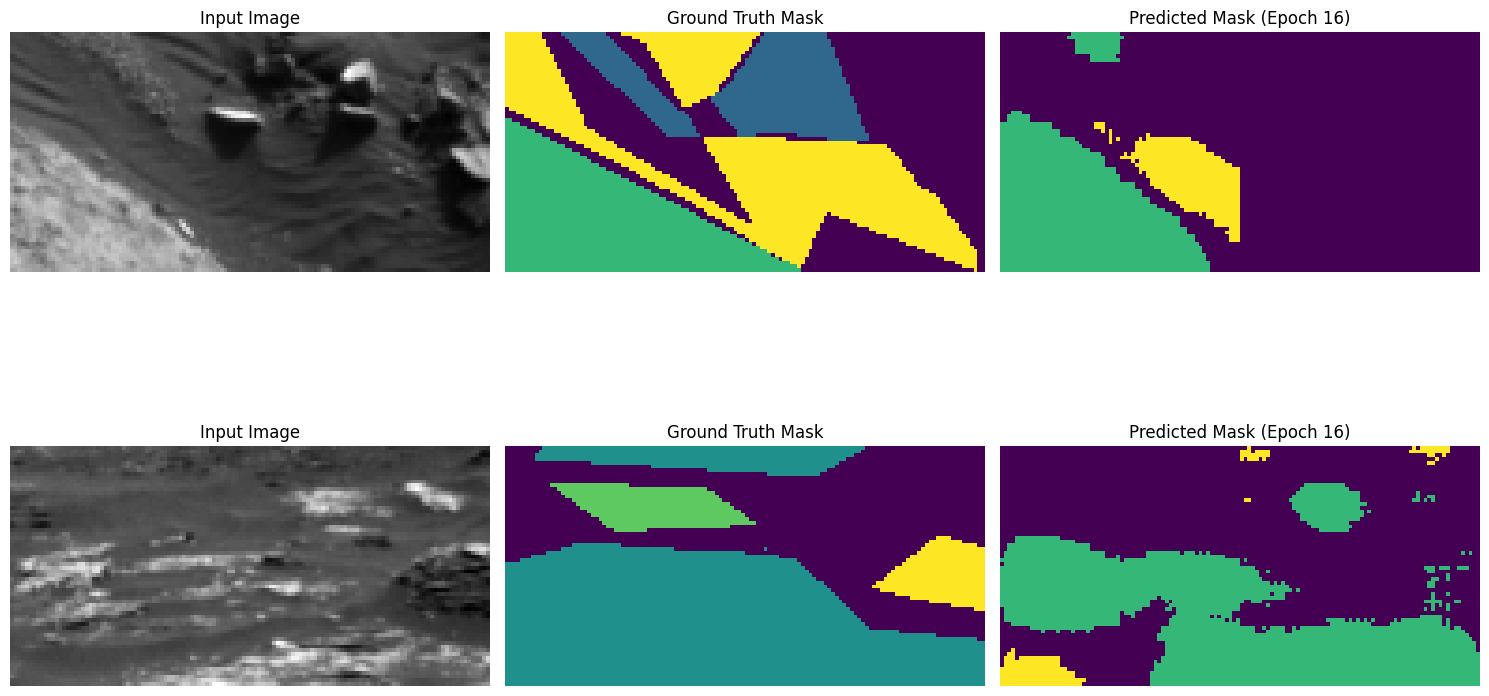

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.7661 - loss: 0.6040 - mean_io_u: 0.4608 - val_accuracy: 0.7432 - val_loss: 0.6813 - val_mean_io_u: 0.4395 - learning_rate: 1.0000e-04
Epoch 17/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7694 - loss: 0.5961 - mean_io_u: 0.4644
Epoch 17: val_loss improved from 0.68128 to 0.66598, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


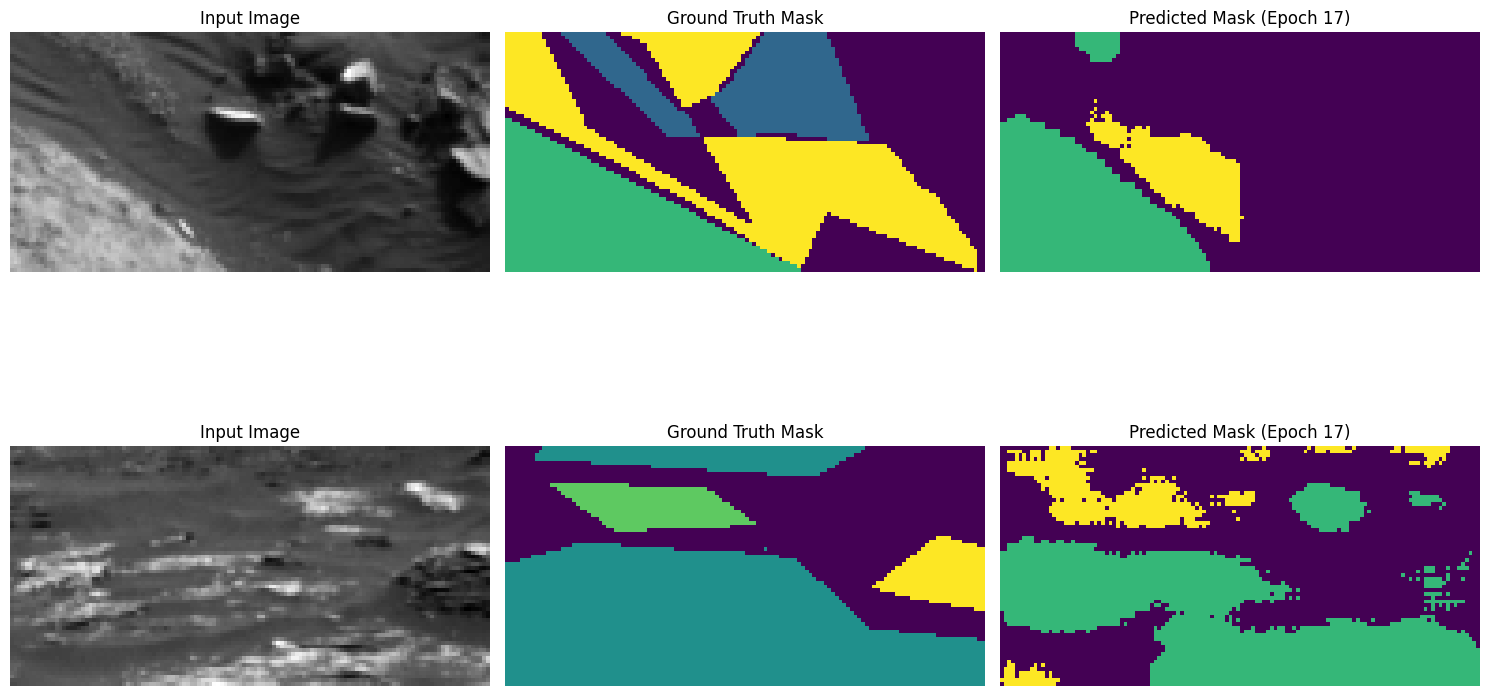

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.7694 - loss: 0.5960 - mean_io_u: 0.4644 - val_accuracy: 0.7522 - val_loss: 0.6660 - val_mean_io_u: 0.4510 - learning_rate: 1.0000e-04
Epoch 18/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7753 - loss: 0.5794 - mean_io_u: 0.4699
Epoch 18: val_loss did not improve from 0.66598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


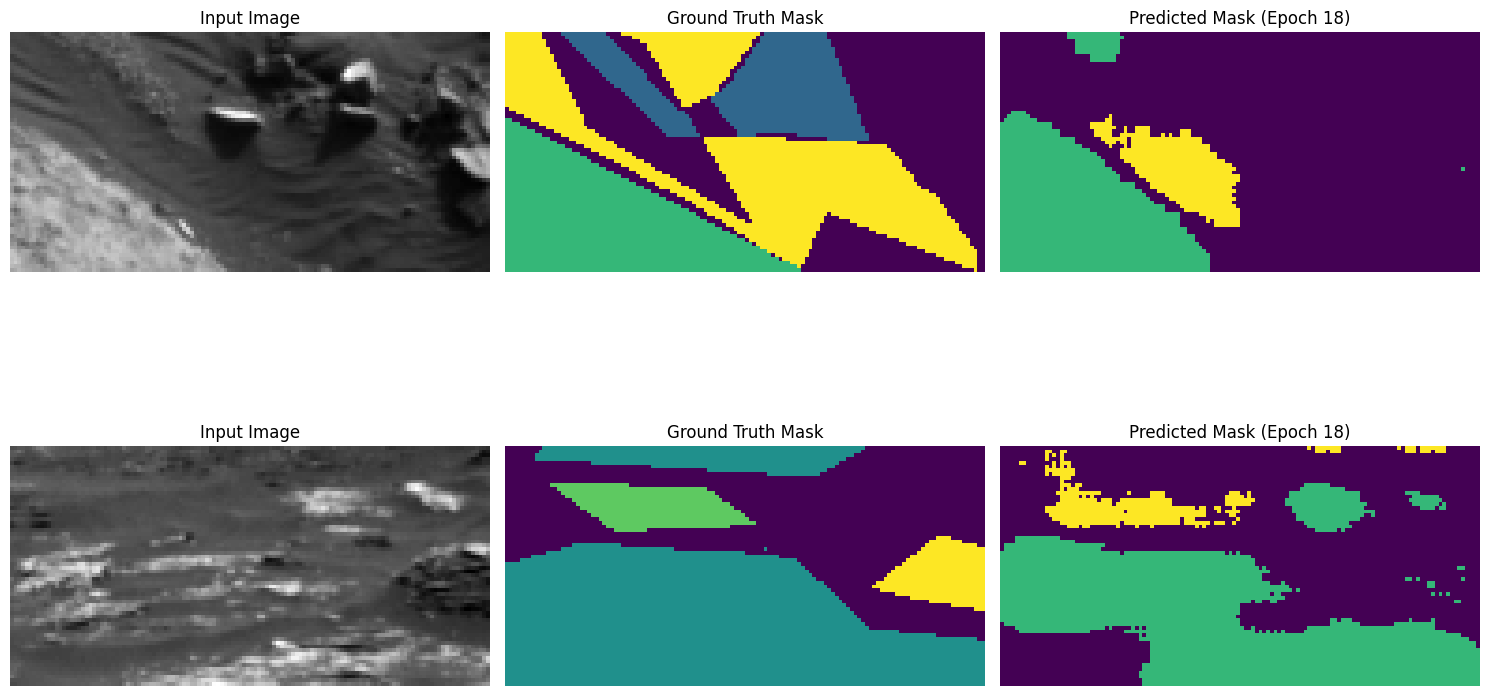

251/251 ━━━━━━━━━━━━━━━━━━━━ 52s 209ms/step - accuracy: 0.7753 - loss: 0.5794 - mean_io_u: 0.4699 - val_accuracy: 0.7549 - val_loss: 0.6723 - val_mean_io_u: 0.4535 - learning_rate: 1.0000e-04
Epoch 19/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7799 - loss: 0.5672 - mean_io_u: 0.4754
Epoch 19: val_loss did not improve from 0.66598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


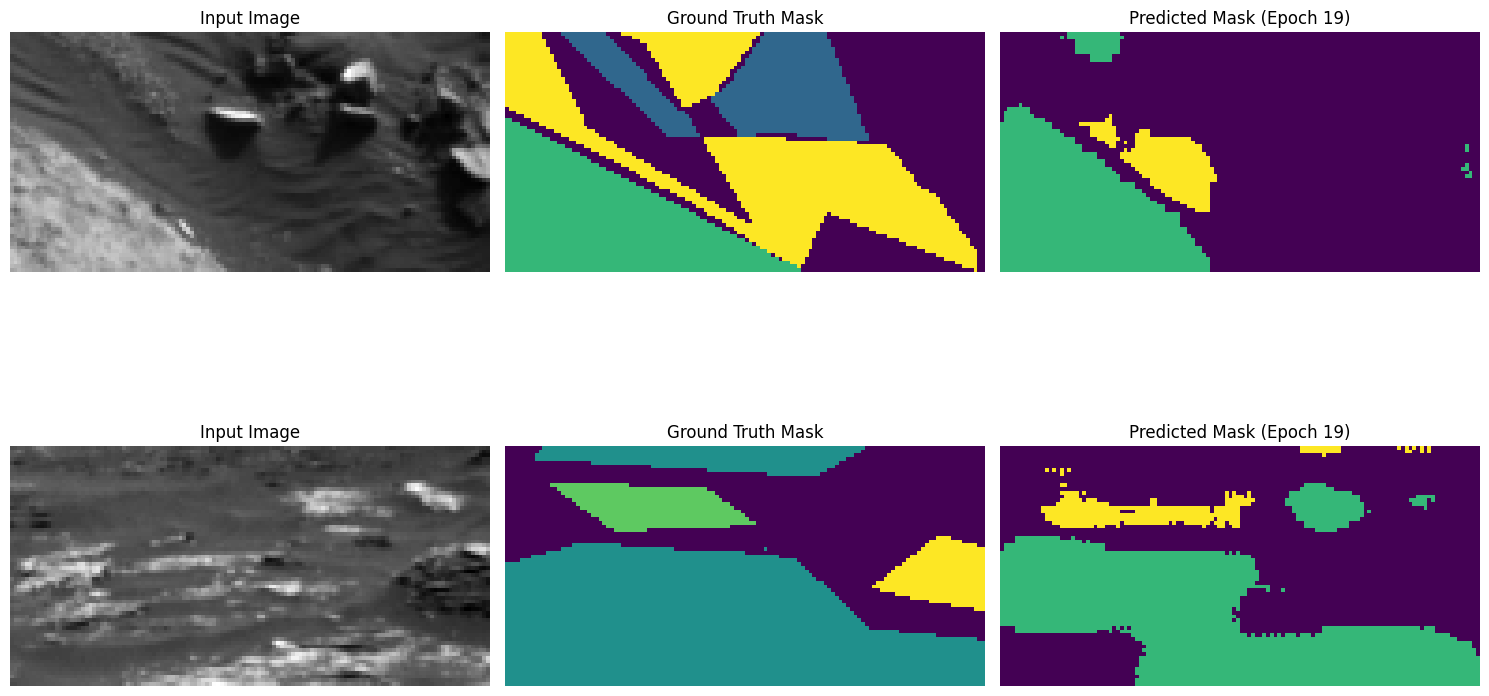

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.7799 - loss: 0.5671 - mean_io_u: 0.4755 - val_accuracy: 0.7478 - val_loss: 0.7037 - val_mean_io_u: 0.4448 - learning_rate: 1.0000e-04
Epoch 20/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7853 - loss: 0.5544 - mean_io_u: 0.4814
Epoch 20: val_loss did not improve from 0.66598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


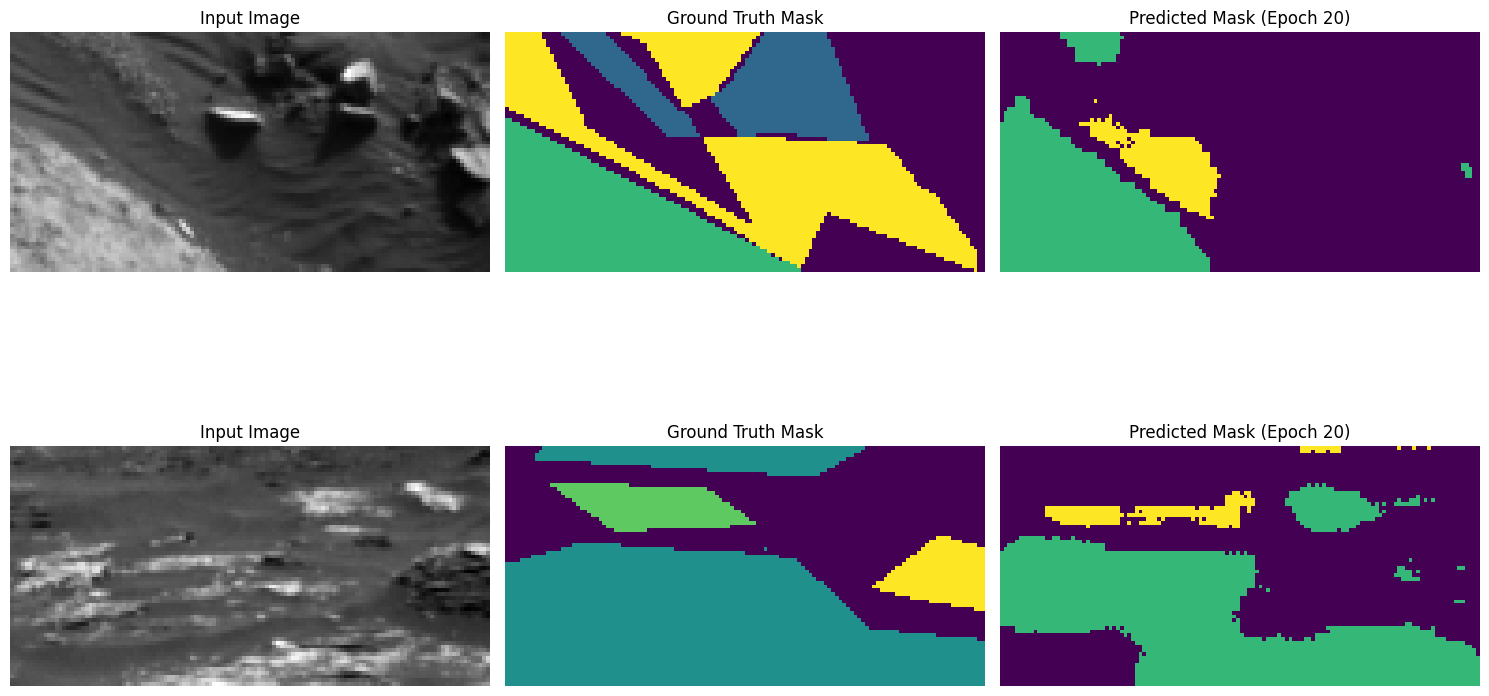

251/251 ━━━━━━━━━━━━━━━━━━━━ 52s 209ms/step - accuracy: 0.7853 - loss: 0.5543 - mean_io_u: 0.4814 - val_accuracy: 0.7464 - val_loss: 0.7124 - val_mean_io_u: 0.4395 - learning_rate: 1.0000e-04
Epoch 21/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7912 - loss: 0.5390 - mean_io_u: 0.4886
Epoch 21: val_loss did not improve from 0.66598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


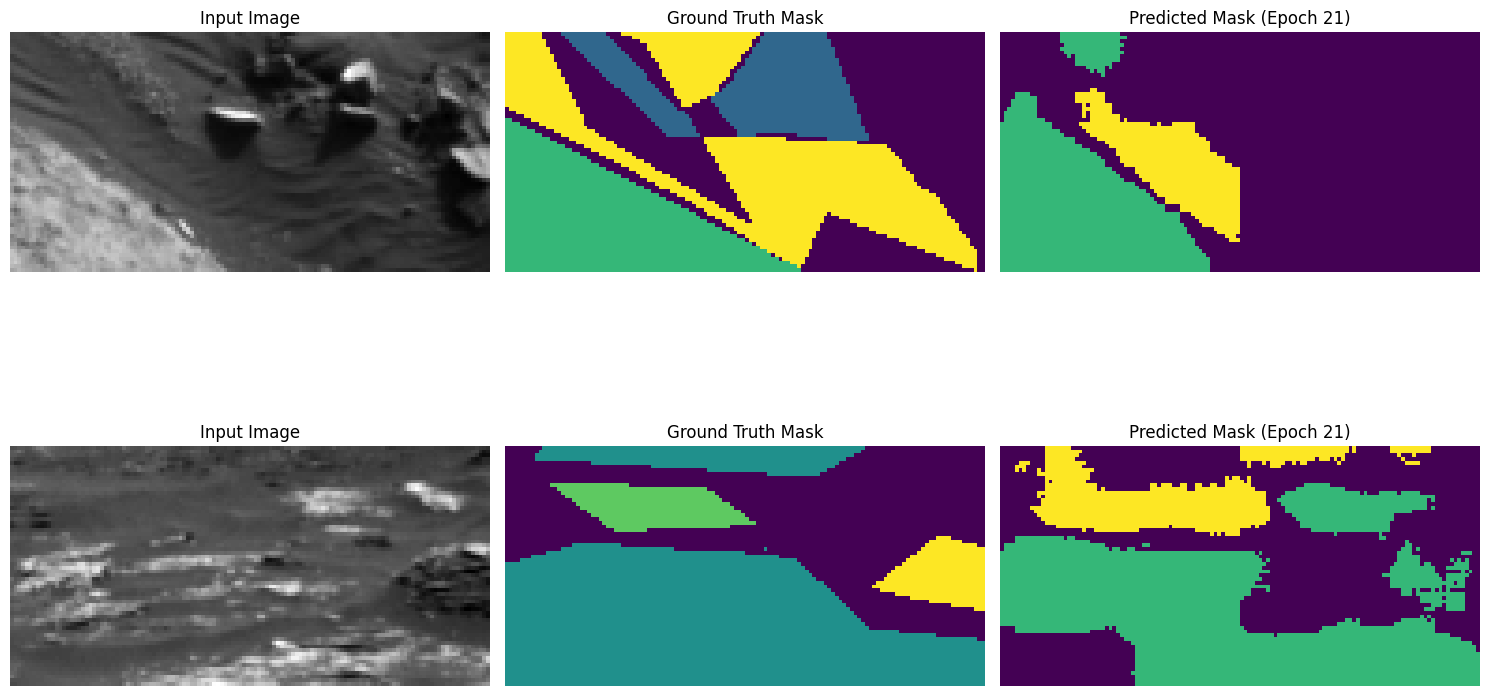

251/251 ━━━━━━━━━━━━━━━━━━━━ 52s 208ms/step - accuracy: 0.7913 - loss: 0.5389 - mean_io_u: 0.4886 - val_accuracy: 0.7553 - val_loss: 0.6895 - val_mean_io_u: 0.4523 - learning_rate: 1.0000e-04
Epoch 22/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7951 - loss: 0.5291 - mean_io_u: 0.4915
Epoch 22: val_loss did not improve from 0.66598

Epoch 22: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


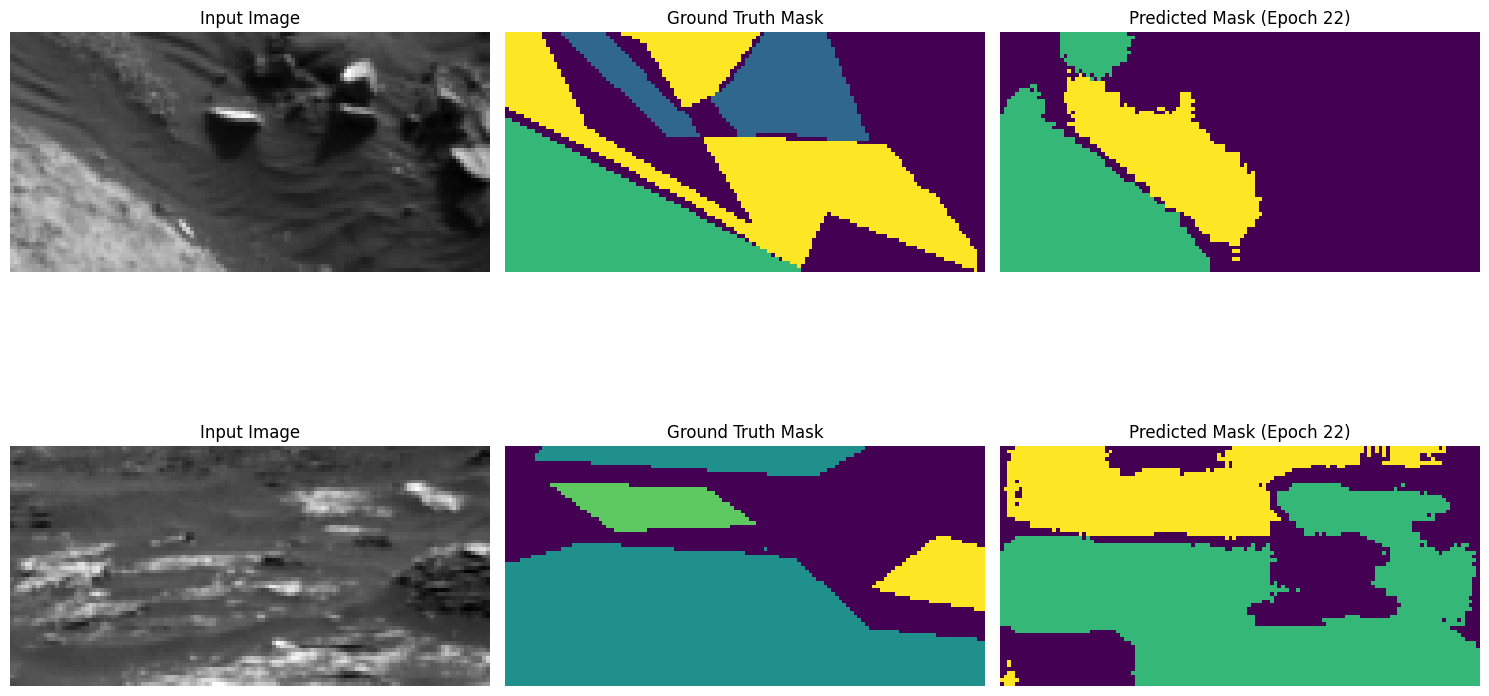

251/251 ━━━━━━━━━━━━━━━━━━━━ 52s 209ms/step - accuracy: 0.7951 - loss: 0.5290 - mean_io_u: 0.4915 - val_accuracy: 0.7577 - val_loss: 0.6874 - val_mean_io_u: 0.4603 - learning_rate: 1.0000e-04
Epoch 23/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8125 - loss: 0.4841 - mean_io_u: 0.5091
Epoch 23: val_loss did not improve from 0.66598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


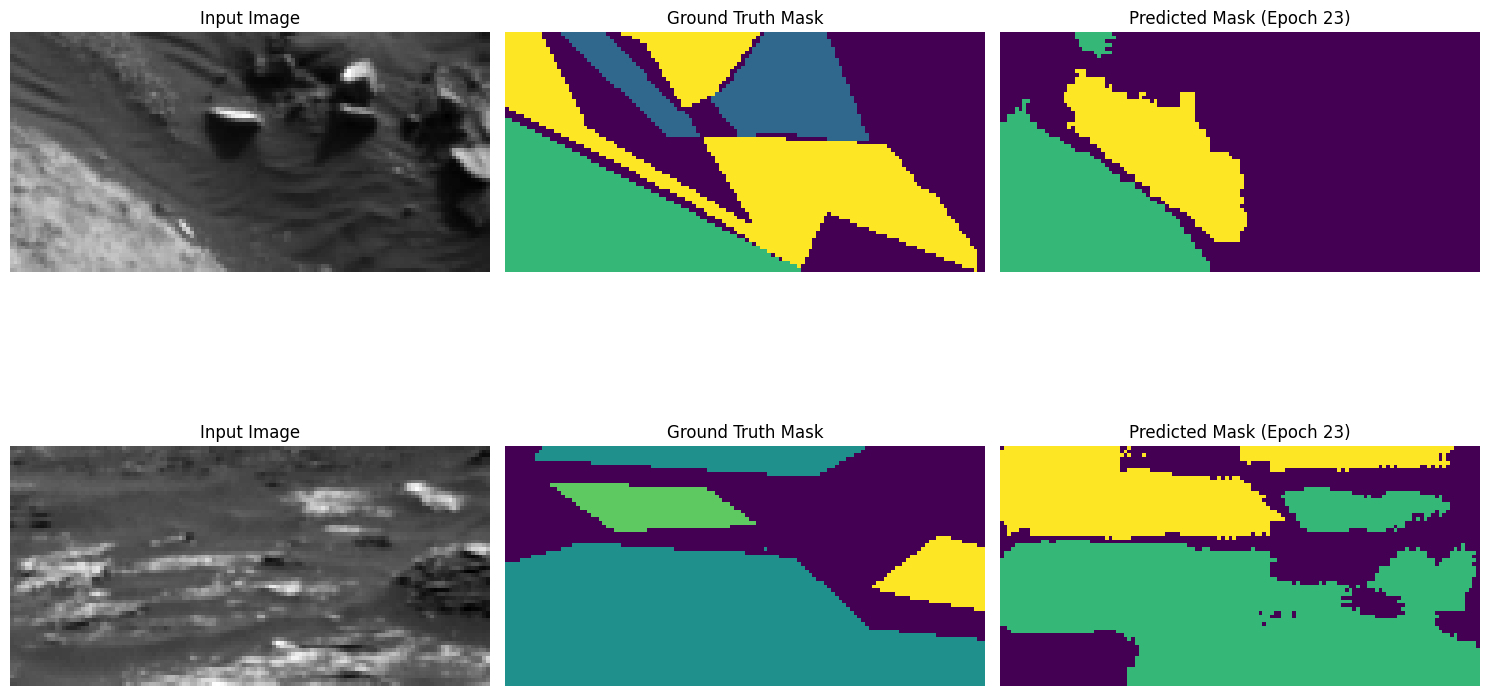

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.8126 - loss: 0.4840 - mean_io_u: 0.5091 - val_accuracy: 0.7481 - val_loss: 0.7106 - val_mean_io_u: 0.4405 - learning_rate: 5.0000e-05
Epoch 24/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8152 - loss: 0.4766 - mean_io_u: 0.5127
Epoch 24: val_loss did not improve from 0.66598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


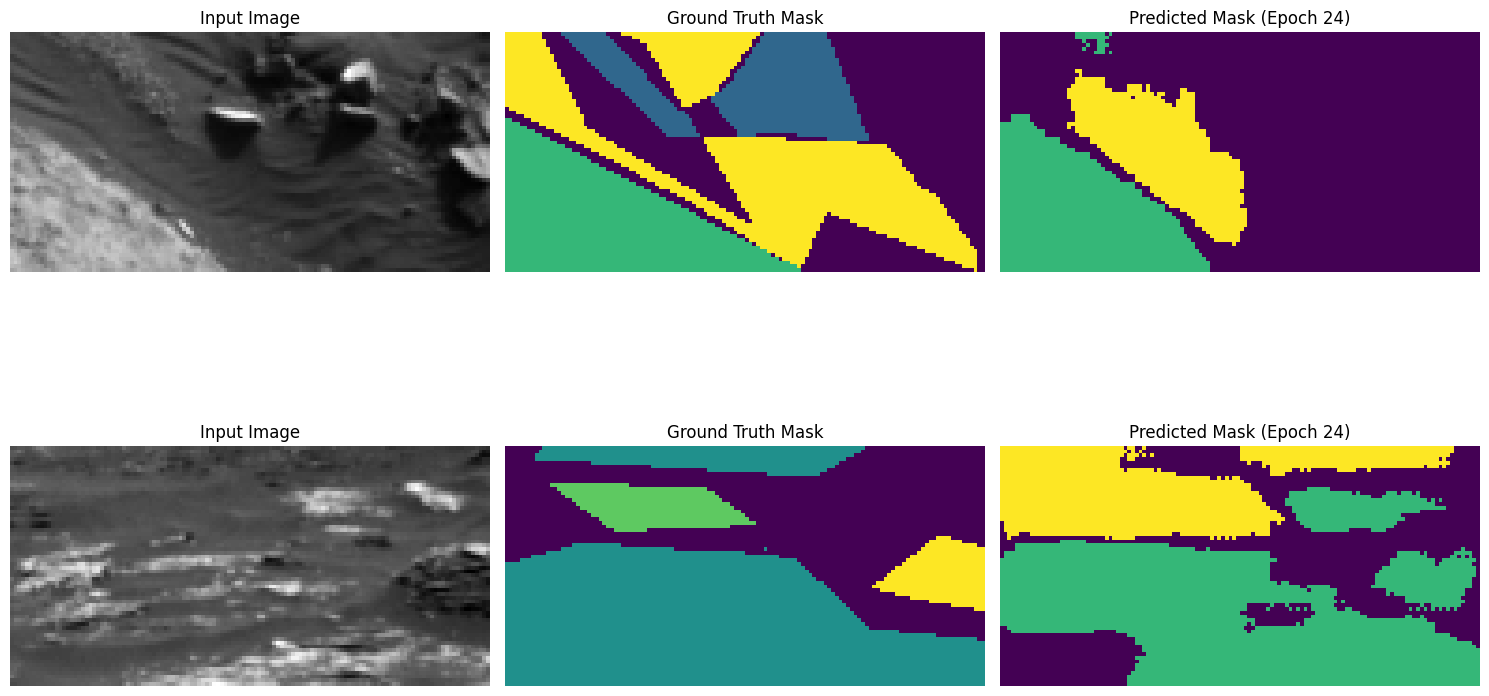

251/251 ━━━━━━━━━━━━━━━━━━━━ 52s 209ms/step - accuracy: 0.8153 - loss: 0.4766 - mean_io_u: 0.5128 - val_accuracy: 0.7451 - val_loss: 0.7332 - val_mean_io_u: 0.4356 - learning_rate: 5.0000e-05
Epoch 25/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8203 - loss: 0.4631 - mean_io_u: 0.5180
Epoch 25: val_loss did not improve from 0.66598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


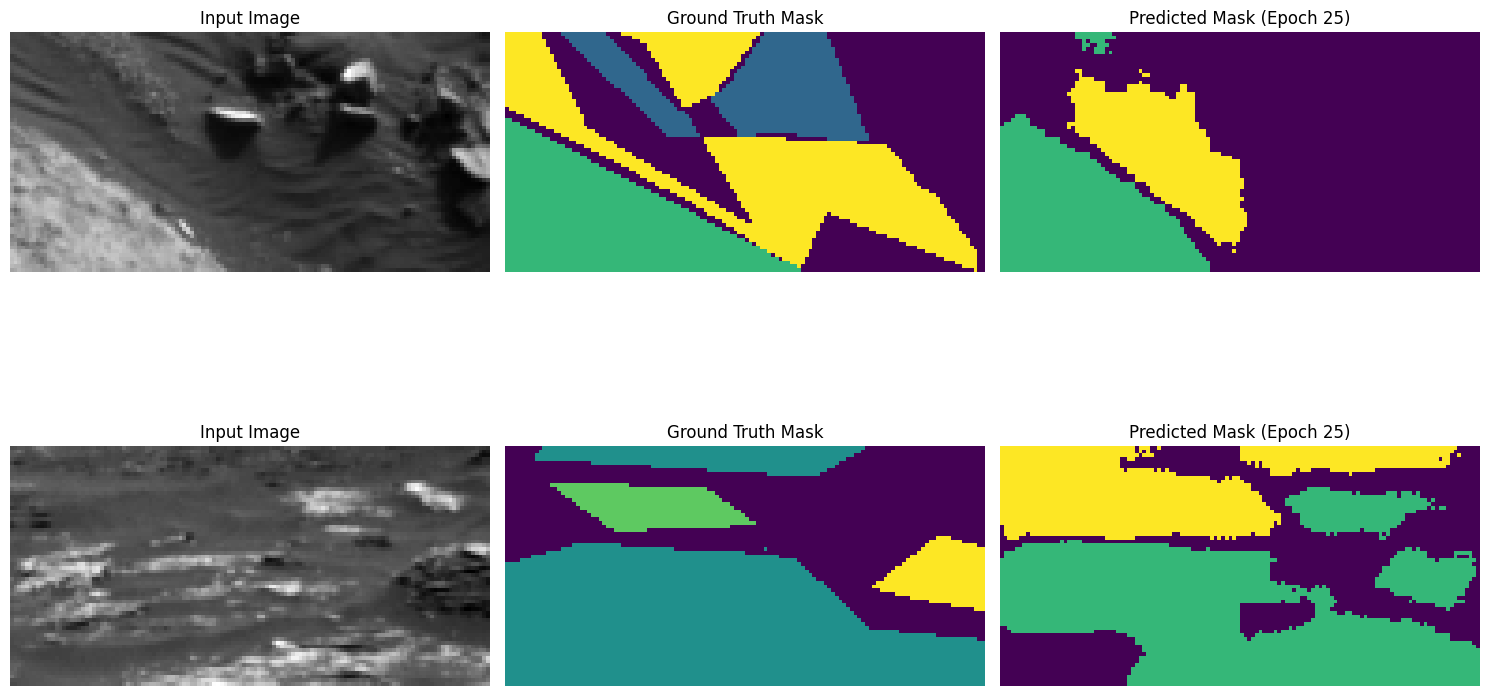

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 209ms/step - accuracy: 0.8203 - loss: 0.4630 - mean_io_u: 0.5180 - val_accuracy: 0.7427 - val_loss: 0.7509 - val_mean_io_u: 0.4328 - learning_rate: 5.0000e-05
Epoch 26/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8252 - loss: 0.4507 - mean_io_u: 0.5231
Epoch 26: val_loss did not improve from 0.66598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


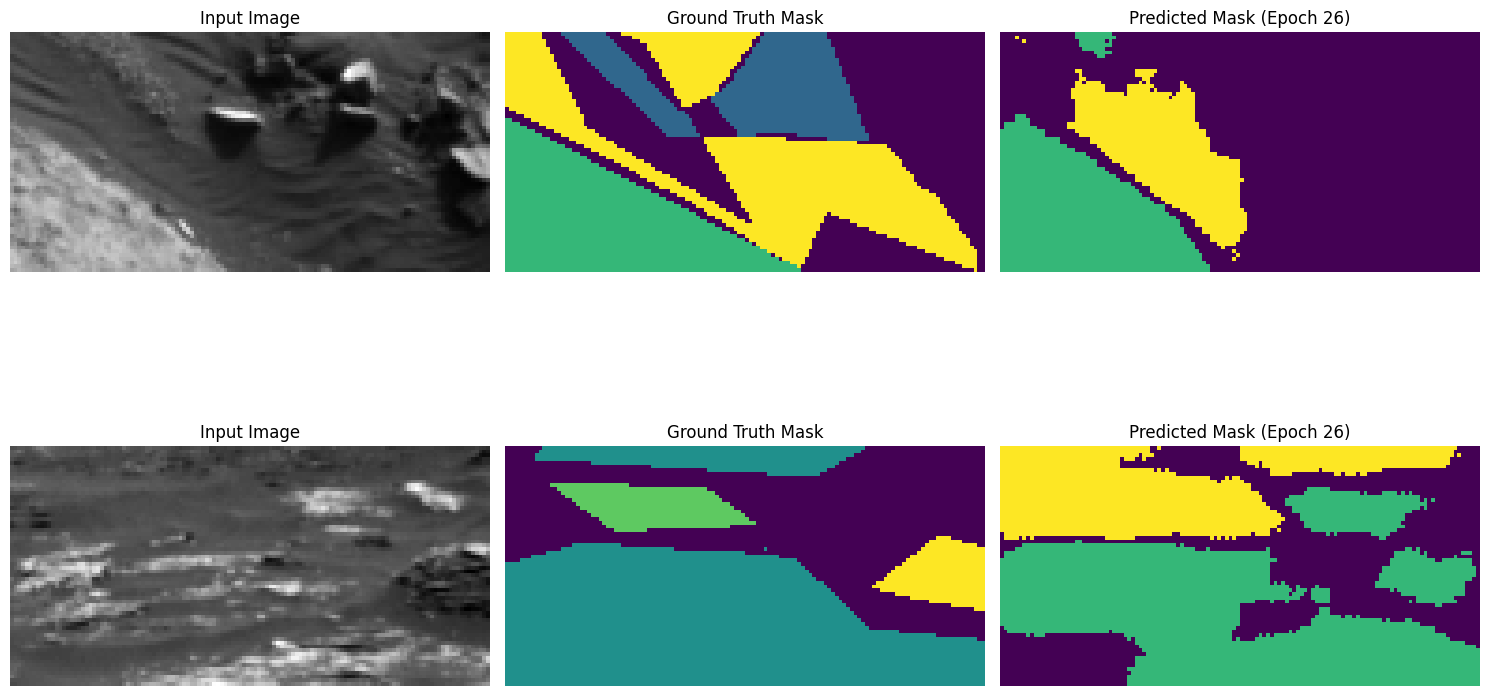

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.8252 - loss: 0.4506 - mean_io_u: 0.5232 - val_accuracy: 0.7415 - val_loss: 0.7662 - val_mean_io_u: 0.4314 - learning_rate: 5.0000e-05
Epoch 27/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8302 - loss: 0.4382 - mean_io_u: 0.5287
Epoch 27: val_loss did not improve from 0.66598

Epoch 27: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


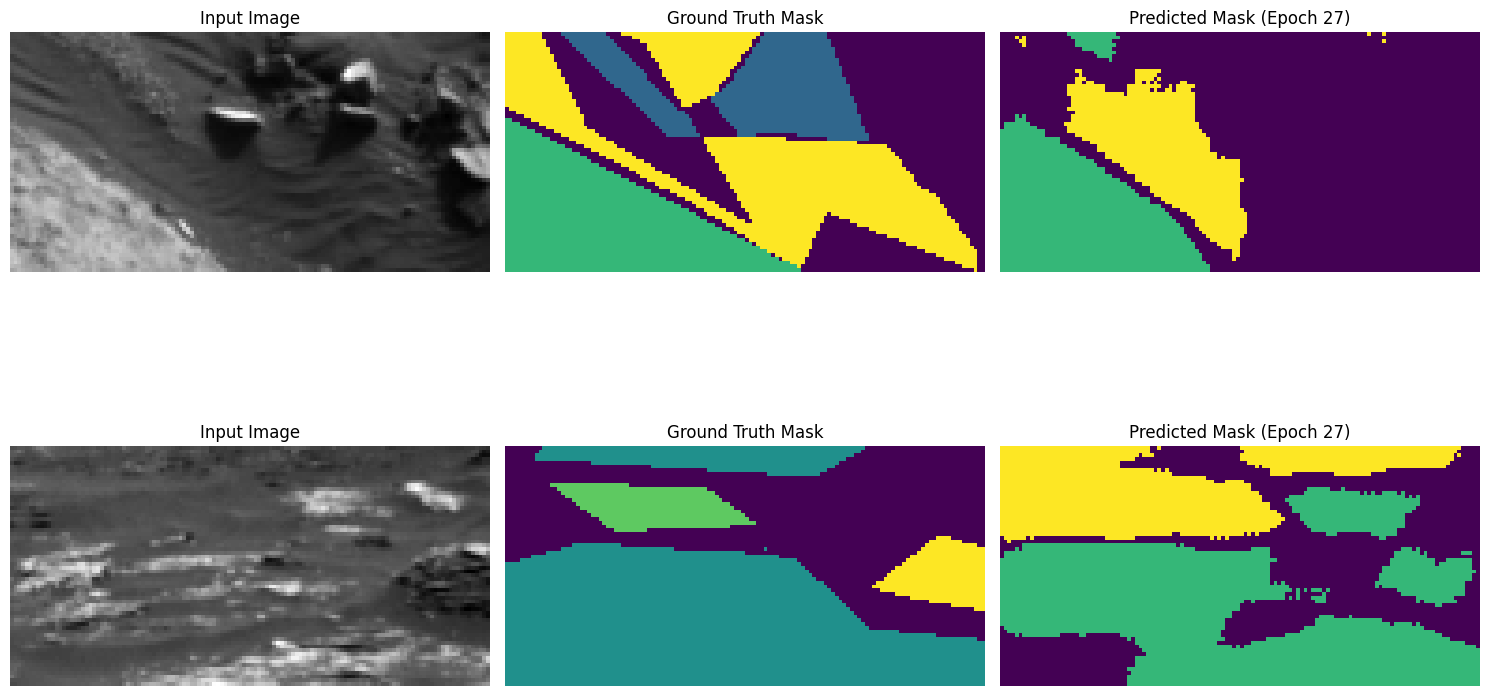

251/251 ━━━━━━━━━━━━━━━━━━━━ 52s 209ms/step - accuracy: 0.8303 - loss: 0.4381 - mean_io_u: 0.5287 - val_accuracy: 0.7403 - val_loss: 0.7803 - val_mean_io_u: 0.4302 - learning_rate: 5.0000e-05
Epoch 28/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8348 - loss: 0.4246 - mean_io_u: 0.5356
Epoch 28: val_loss improved from 0.66598 to 0.66434, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


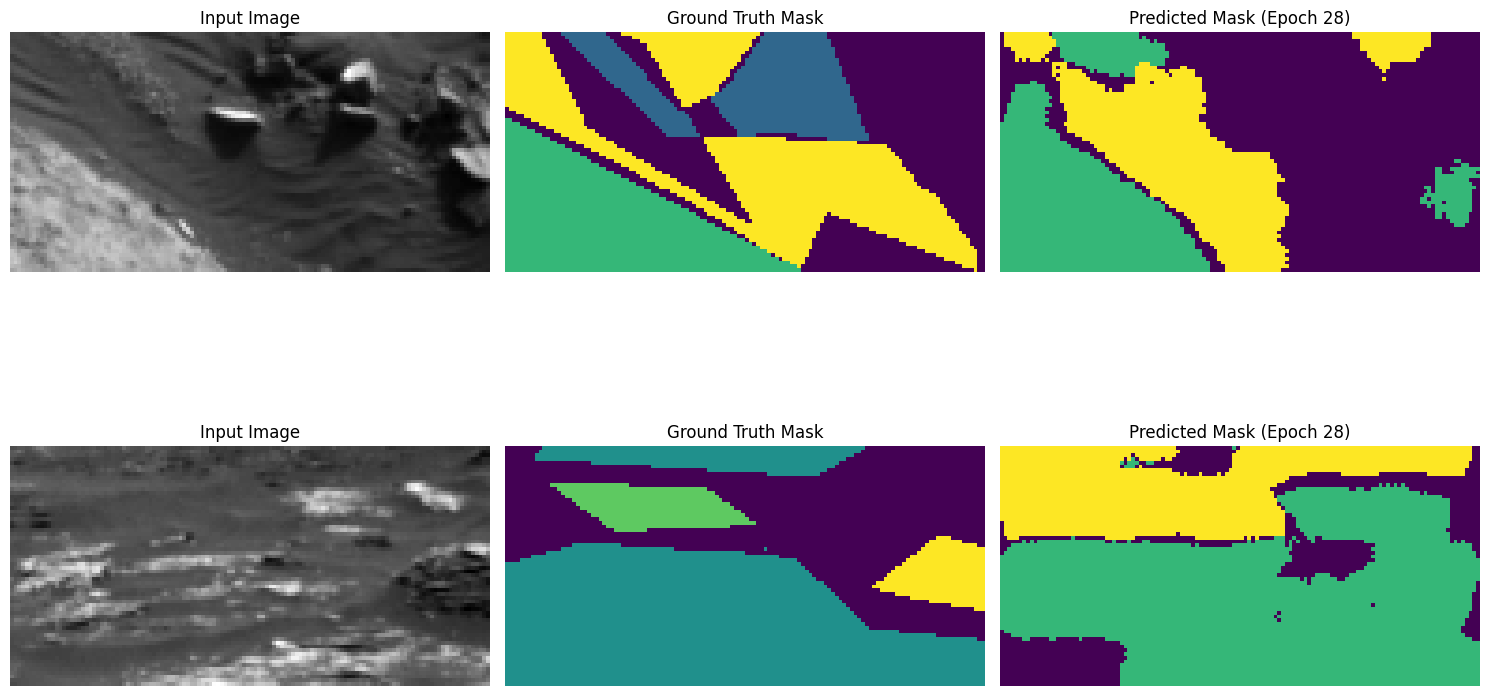

251/251 ━━━━━━━━━━━━━━━━━━━━ 54s 214ms/step - accuracy: 0.8348 - loss: 0.4245 - mean_io_u: 0.5357 - val_accuracy: 0.7655 - val_loss: 0.6643 - val_mean_io_u: 0.4693 - learning_rate: 2.5000e-05
Epoch 29/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8426 - loss: 0.4056 - mean_io_u: 0.5465
Epoch 29: val_loss did not improve from 0.66434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


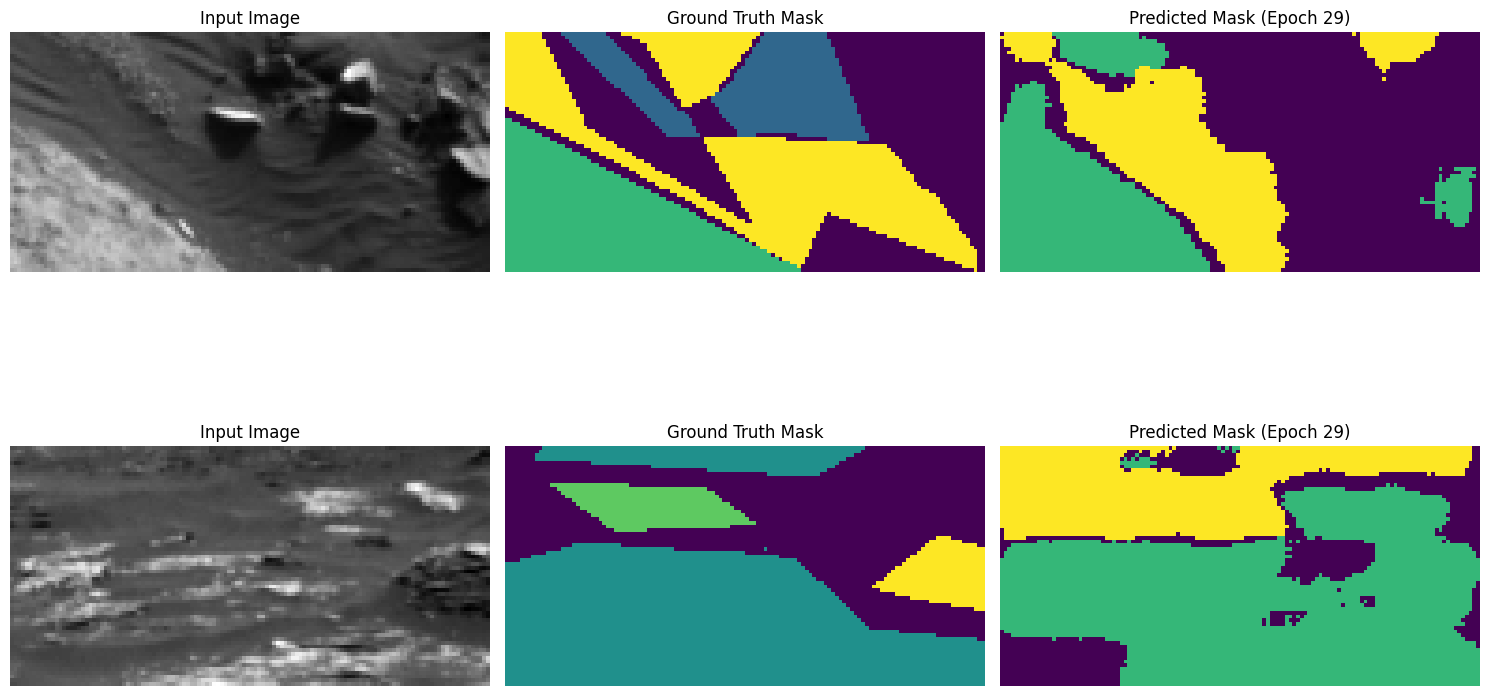

251/251 ━━━━━━━━━━━━━━━━━━━━ 52s 209ms/step - accuracy: 0.8427 - loss: 0.4055 - mean_io_u: 0.5465 - val_accuracy: 0.7653 - val_loss: 0.6698 - val_mean_io_u: 0.4677 - learning_rate: 2.5000e-05
Epoch 30/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8469 - loss: 0.3951 - mean_io_u: 0.5494
Epoch 30: val_loss did not improve from 0.66434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


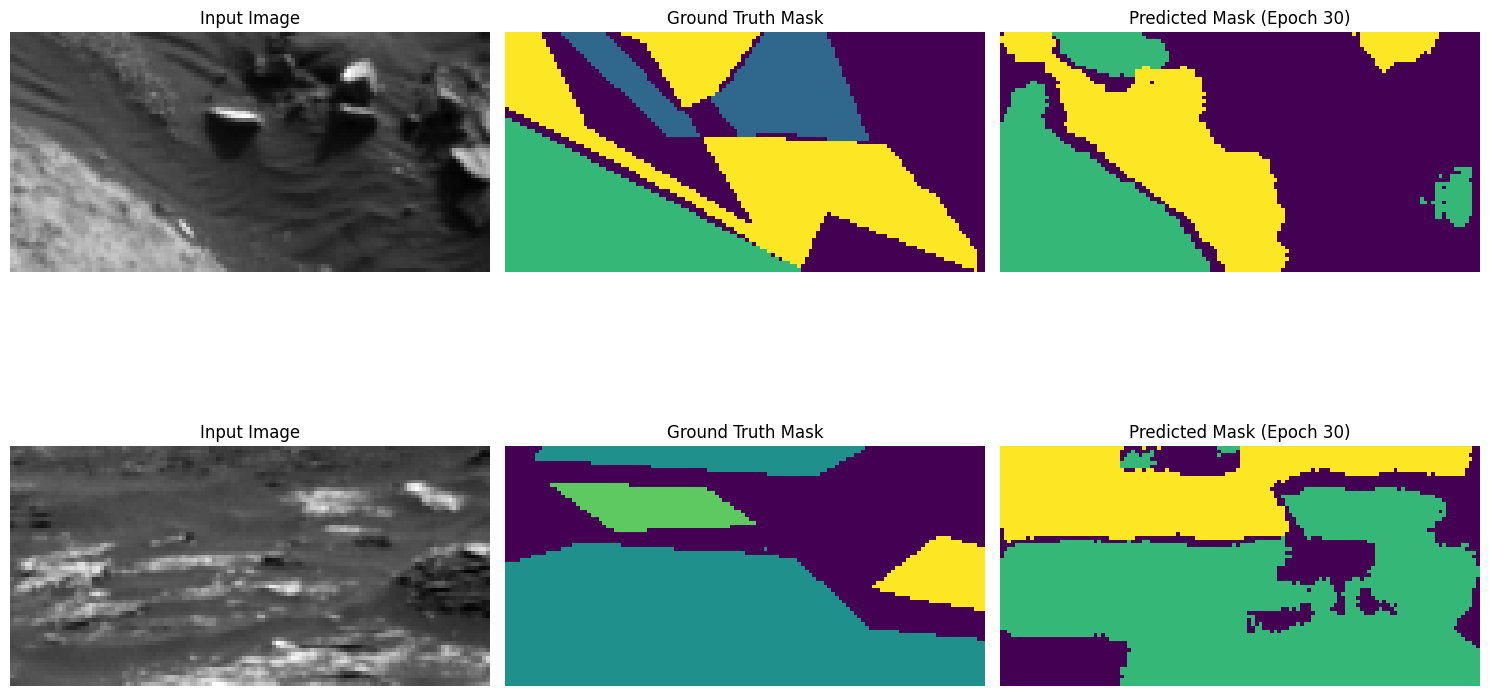

251/251 ━━━━━━━━━━━━━━━━━━━━ 52s 209ms/step - accuracy: 0.8470 - loss: 0.3950 - mean_io_u: 0.5495 - val_accuracy: 0.7649 - val_loss: 0.6766 - val_mean_io_u: 0.4659 - learning_rate: 2.5000e-05
Epoch 31/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8509 - loss: 0.3855 - mean_io_u: 0.5524
Epoch 31: val_loss did not improve from 0.66434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


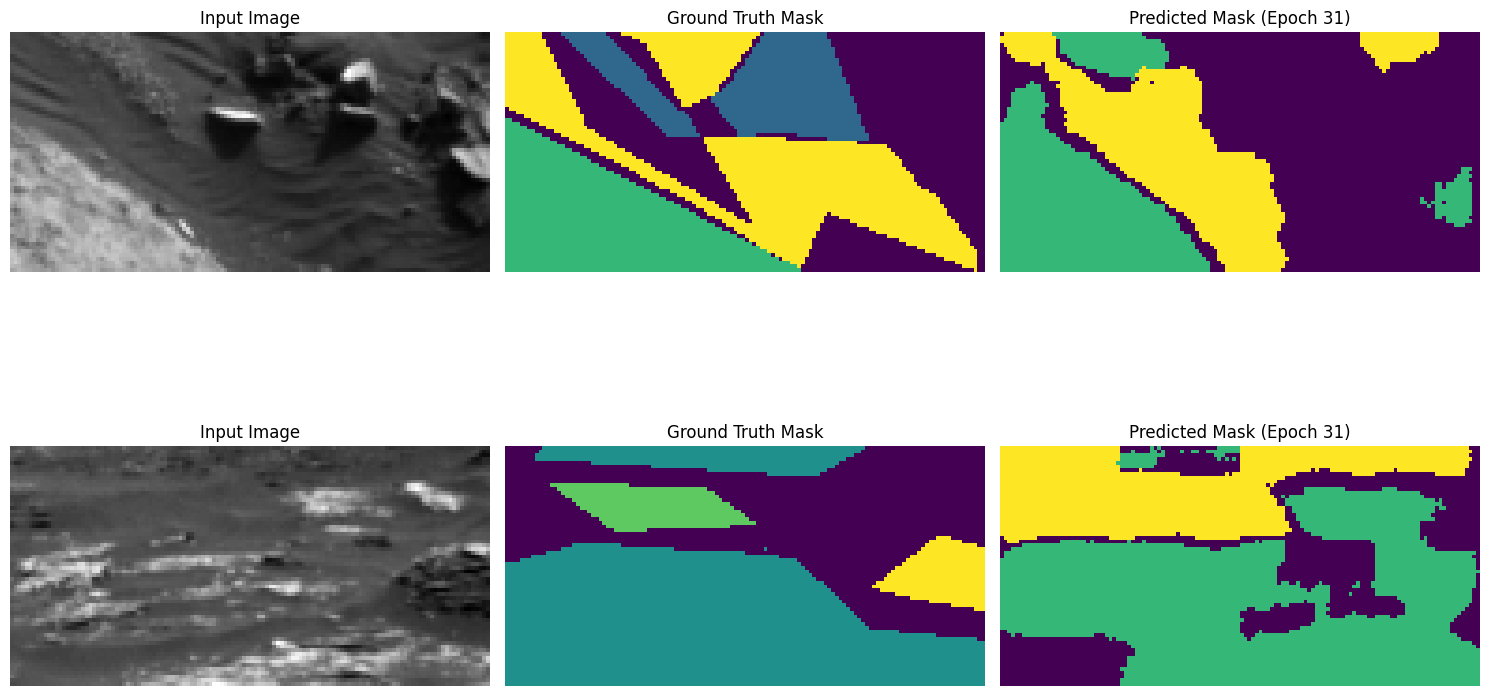

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.8510 - loss: 0.3854 - mean_io_u: 0.5525 - val_accuracy: 0.7647 - val_loss: 0.6830 - val_mean_io_u: 0.4645 - learning_rate: 2.5000e-05
Epoch 32/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8548 - loss: 0.3762 - mean_io_u: 0.5553
Epoch 32: val_loss did not improve from 0.66434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


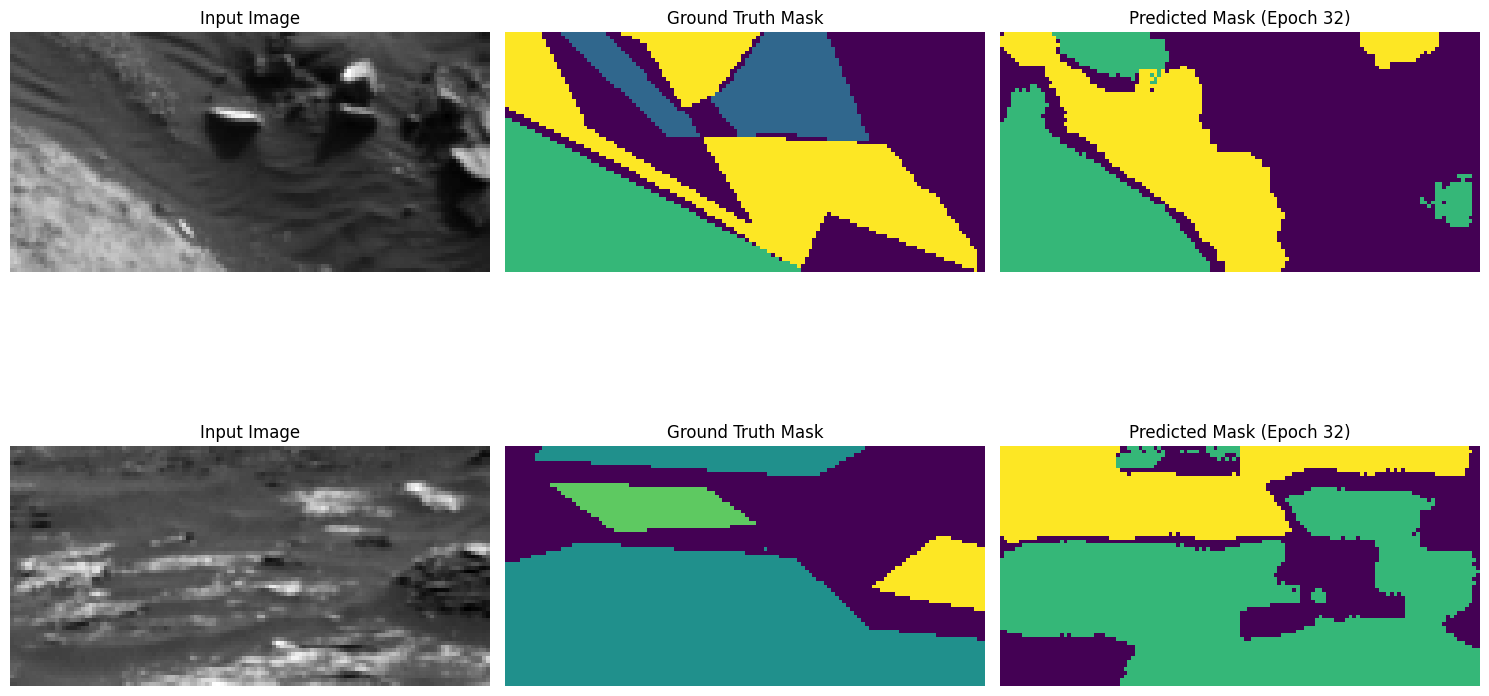

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.8548 - loss: 0.3762 - mean_io_u: 0.5553 - val_accuracy: 0.7647 - val_loss: 0.6891 - val_mean_io_u: 0.4633 - learning_rate: 2.5000e-05
Epoch 33/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8584 - loss: 0.3675 - mean_io_u: 0.5583
Epoch 33: val_loss did not improve from 0.66434

Epoch 33: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


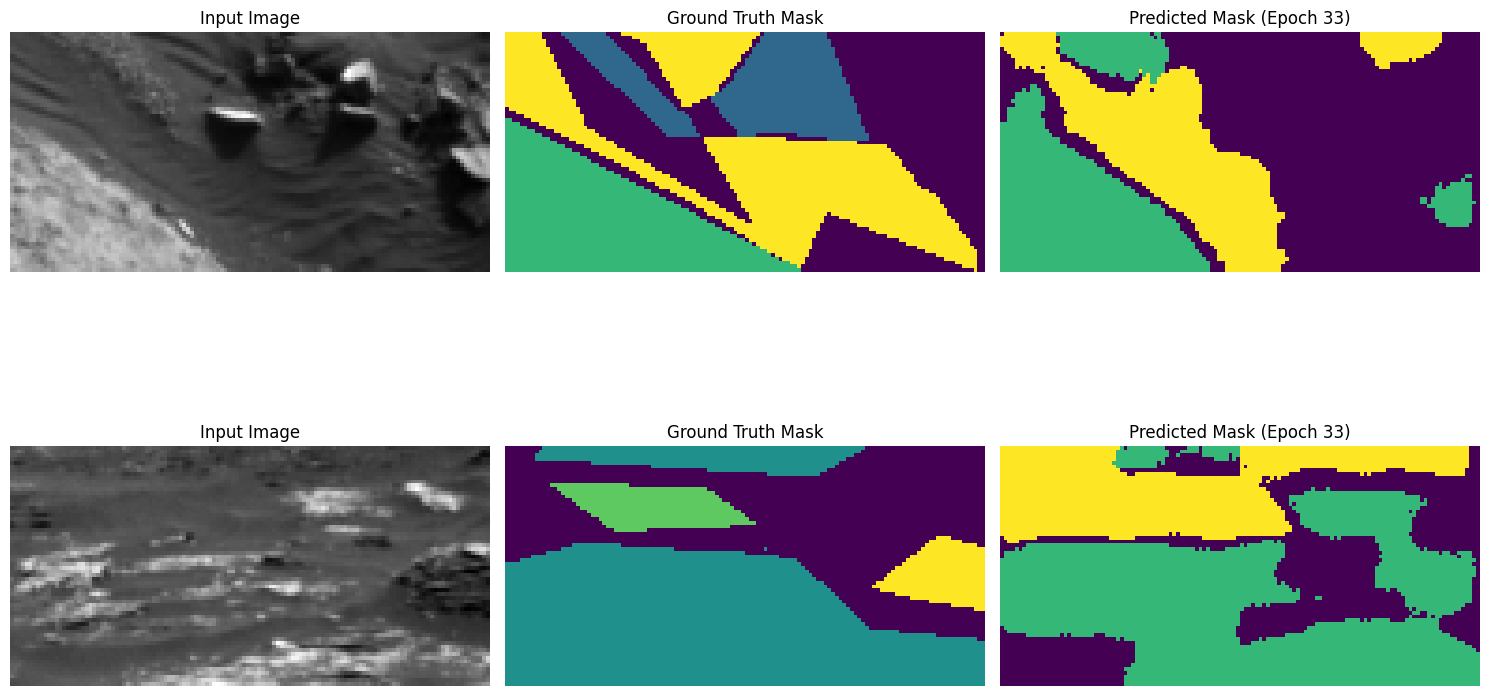

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 212ms/step - accuracy: 0.8585 - loss: 0.3674 - mean_io_u: 0.5583 - val_accuracy: 0.7646 - val_loss: 0.6961 - val_mean_io_u: 0.4624 - learning_rate: 2.5000e-05
Epoch 34/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8624 - loss: 0.3578 - mean_io_u: 0.5626
Epoch 34: val_loss did not improve from 0.66434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


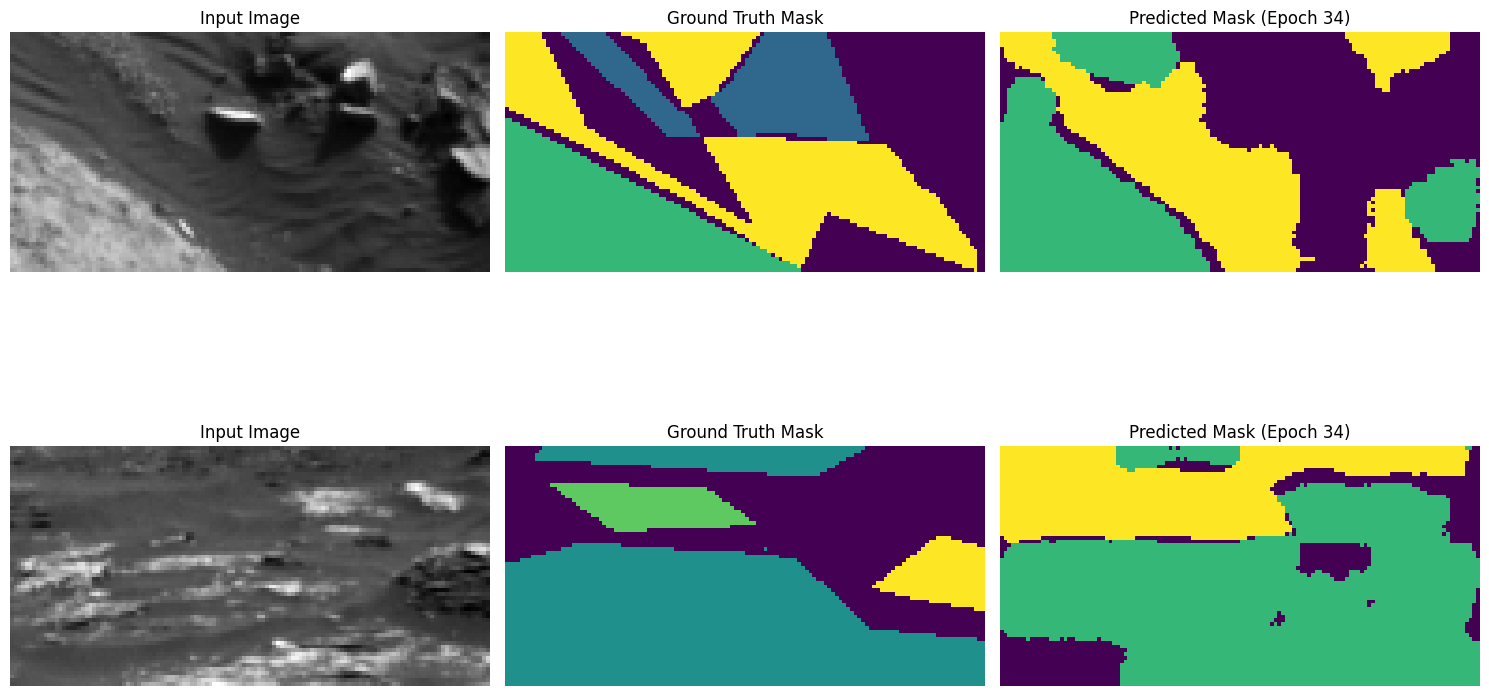

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.8624 - loss: 0.3578 - mean_io_u: 0.5626 - val_accuracy: 0.7666 - val_loss: 0.6930 - val_mean_io_u: 0.4726 - learning_rate: 1.2500e-05
Epoch 35/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8649 - loss: 0.3515 - mean_io_u: 0.5658
Epoch 35: val_loss did not improve from 0.66434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


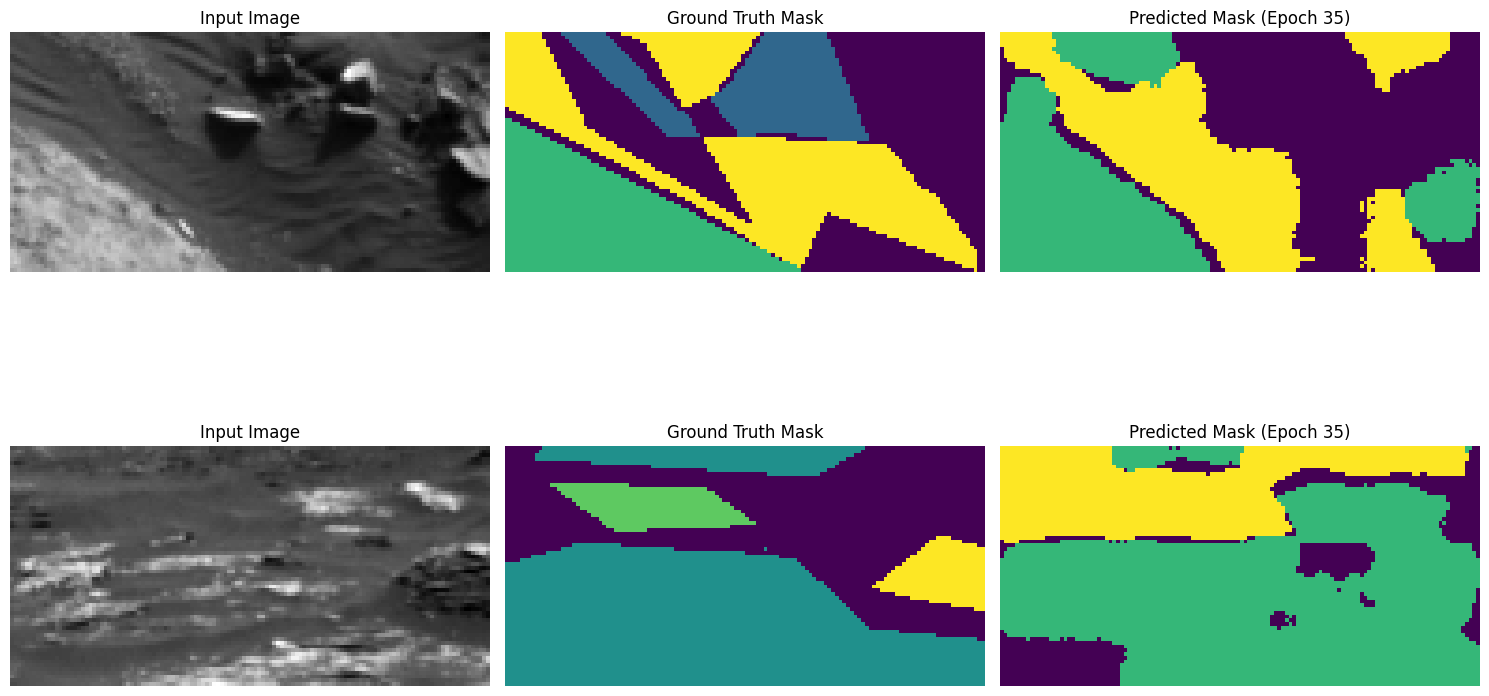

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.8649 - loss: 0.3514 - mean_io_u: 0.5659 - val_accuracy: 0.7669 - val_loss: 0.6968 - val_mean_io_u: 0.4726 - learning_rate: 1.2500e-05
Epoch 36/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8673 - loss: 0.3455 - mean_io_u: 0.5675
Epoch 36: val_loss did not improve from 0.66434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


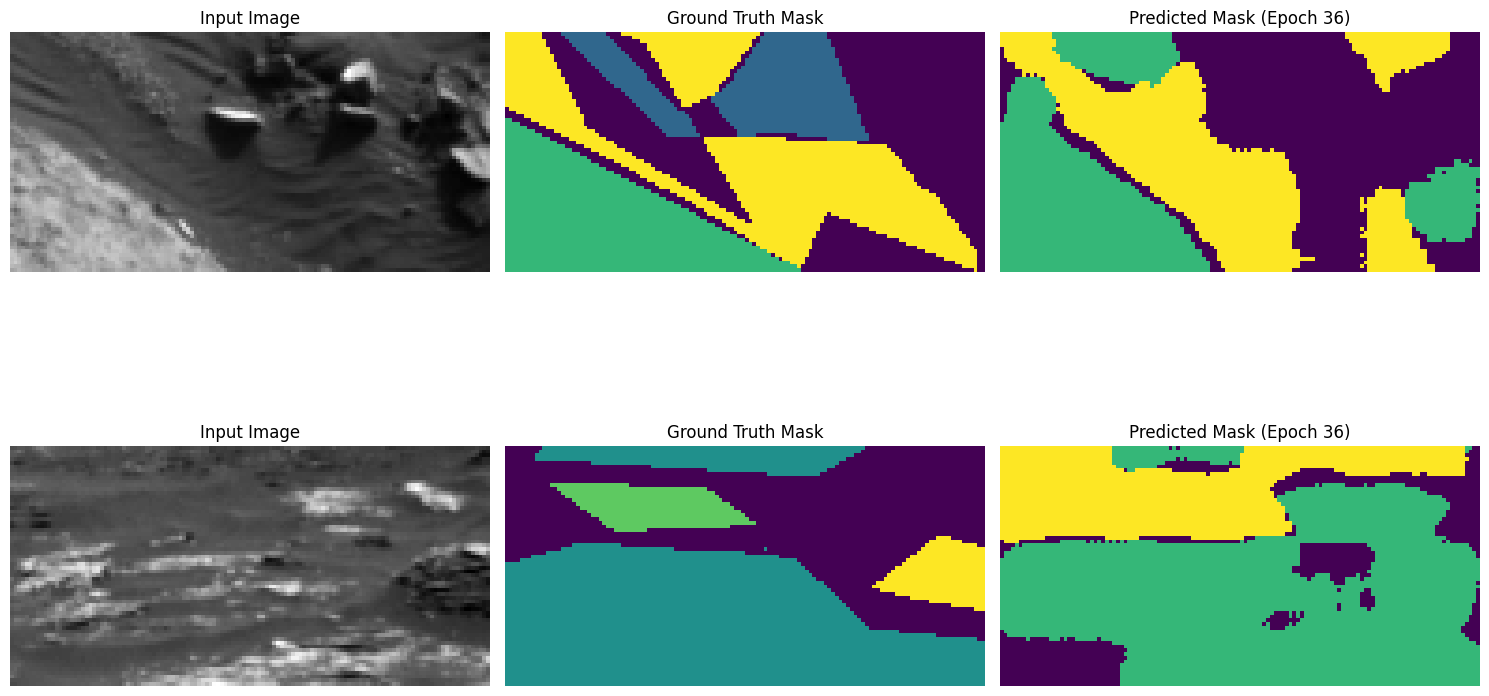

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.8674 - loss: 0.3455 - mean_io_u: 0.5675 - val_accuracy: 0.7670 - val_loss: 0.7012 - val_mean_io_u: 0.4723 - learning_rate: 1.2500e-05
Epoch 37/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8696 - loss: 0.3400 - mean_io_u: 0.5691
Epoch 37: val_loss did not improve from 0.66434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


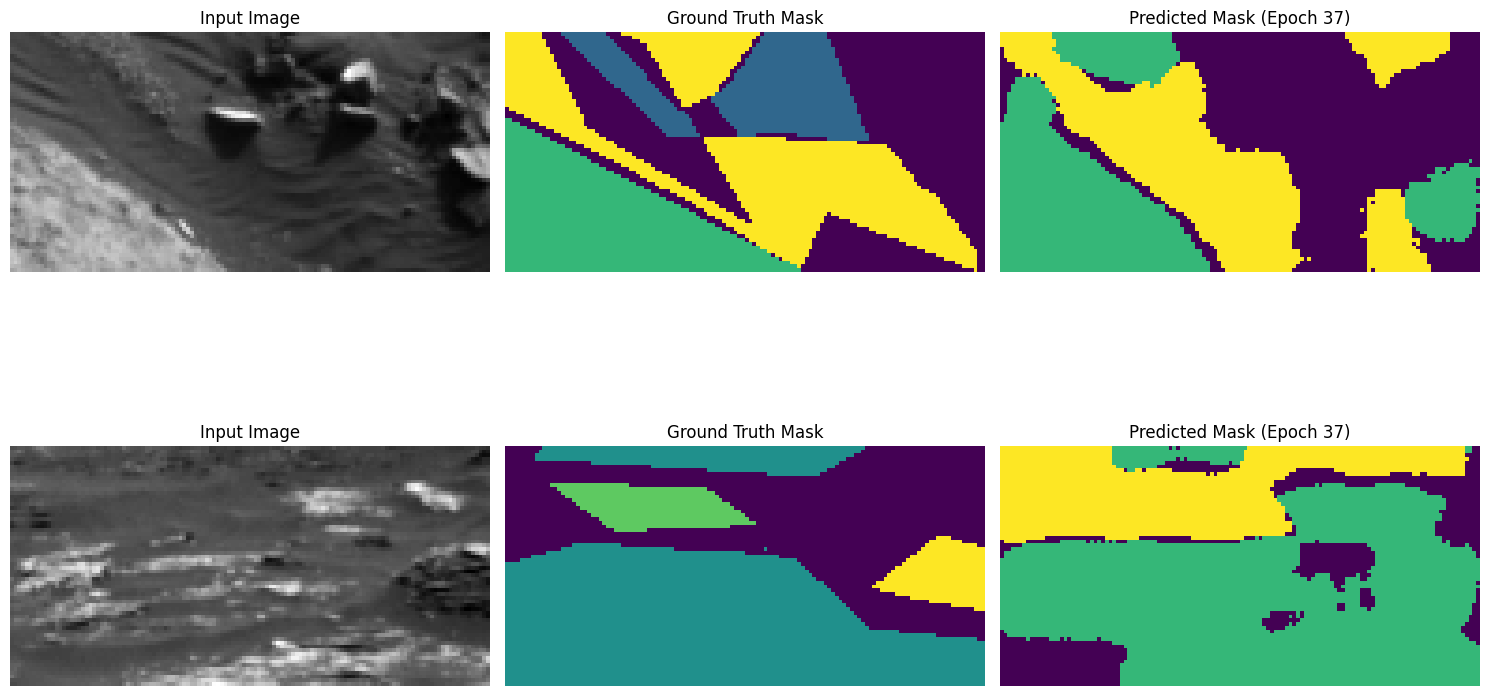

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.8696 - loss: 0.3399 - mean_io_u: 0.5691 - val_accuracy: 0.7669 - val_loss: 0.7060 - val_mean_io_u: 0.4719 - learning_rate: 1.2500e-05
Epoch 38/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8718 - loss: 0.3346 - mean_io_u: 0.5707
Epoch 38: val_loss did not improve from 0.66434

Epoch 38: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


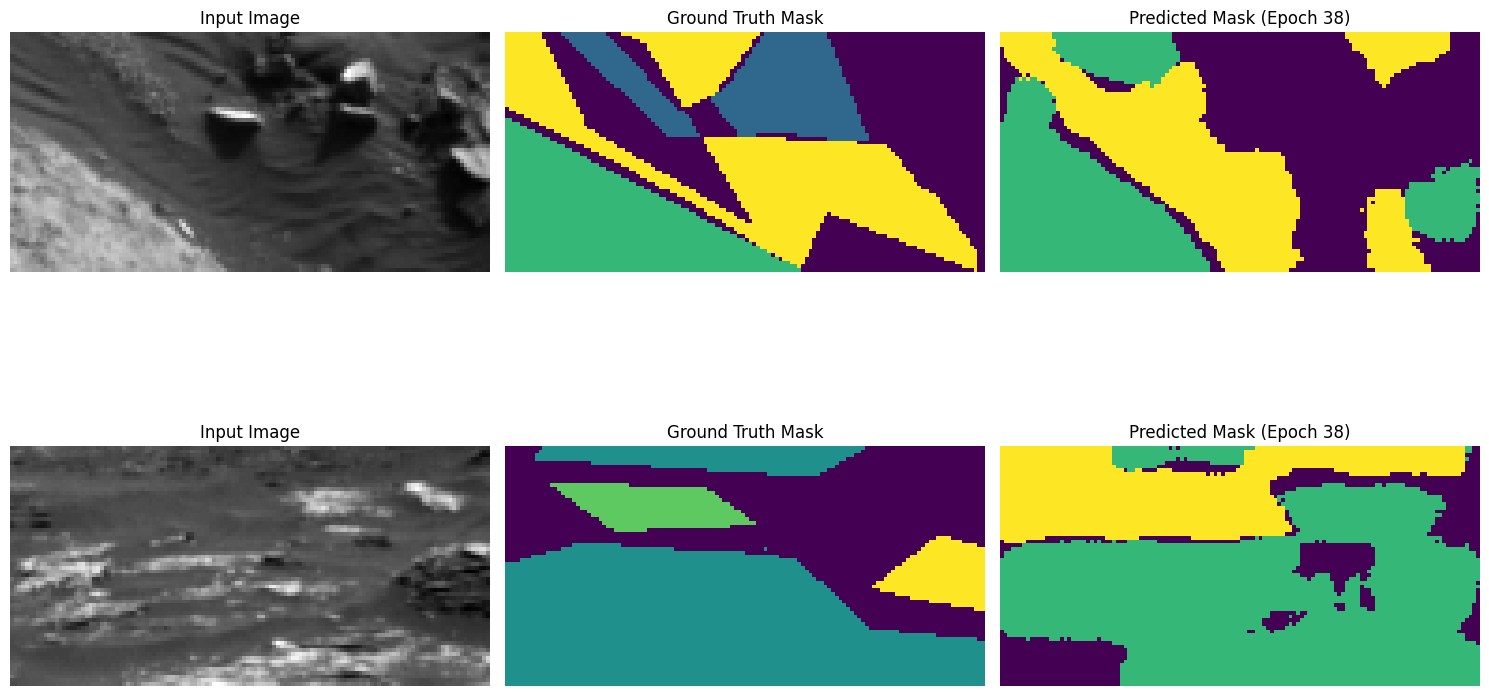

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 212ms/step - accuracy: 0.8719 - loss: 0.3345 - mean_io_u: 0.5708 - val_accuracy: 0.7670 - val_loss: 0.7107 - val_mean_io_u: 0.4717 - learning_rate: 1.2500e-05
Epoch 39/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8736 - loss: 0.3301 - mean_io_u: 0.5721
Epoch 39: val_loss did not improve from 0.66434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


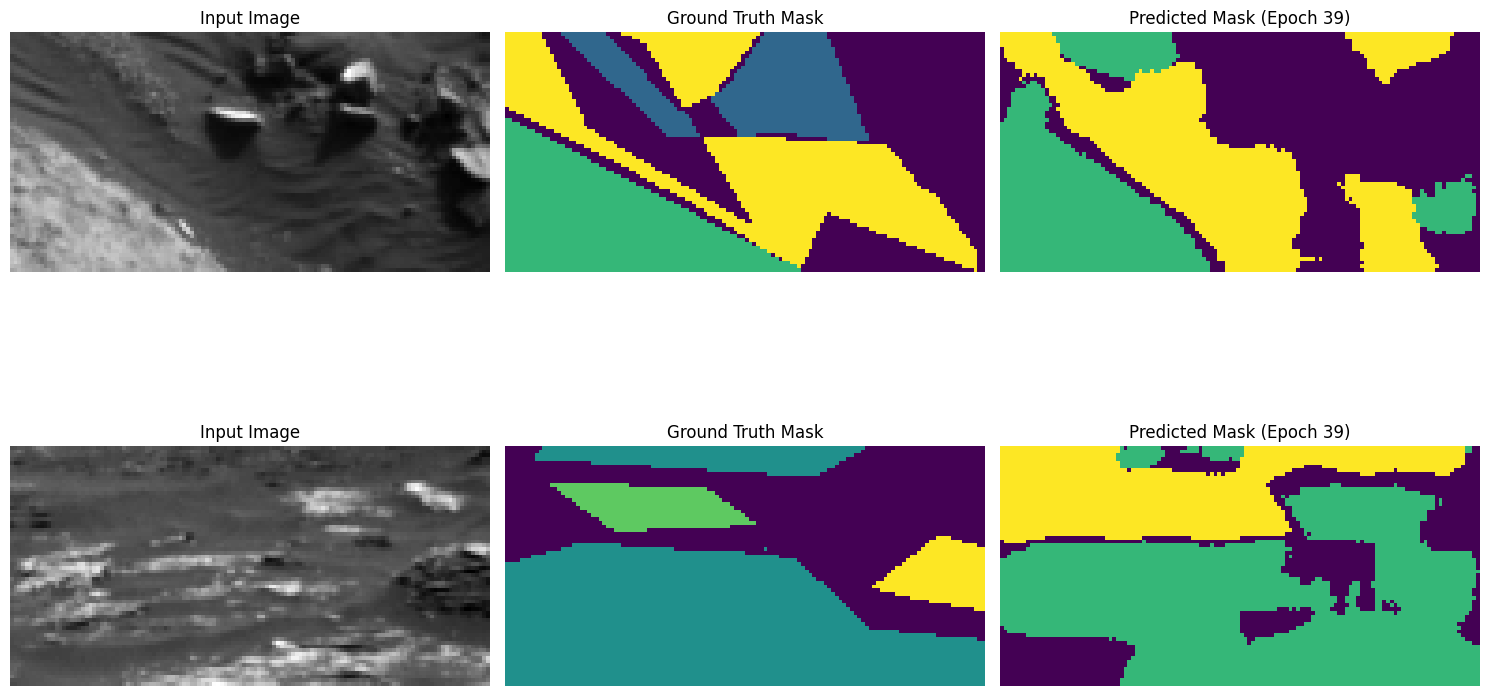

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.8736 - loss: 0.3300 - mean_io_u: 0.5722 - val_accuracy: 0.7697 - val_loss: 0.7025 - val_mean_io_u: 0.4727 - learning_rate: 6.2500e-06
Epoch 40/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8754 - loss: 0.3262 - mean_io_u: 0.5741
Epoch 40: val_loss did not improve from 0.66434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


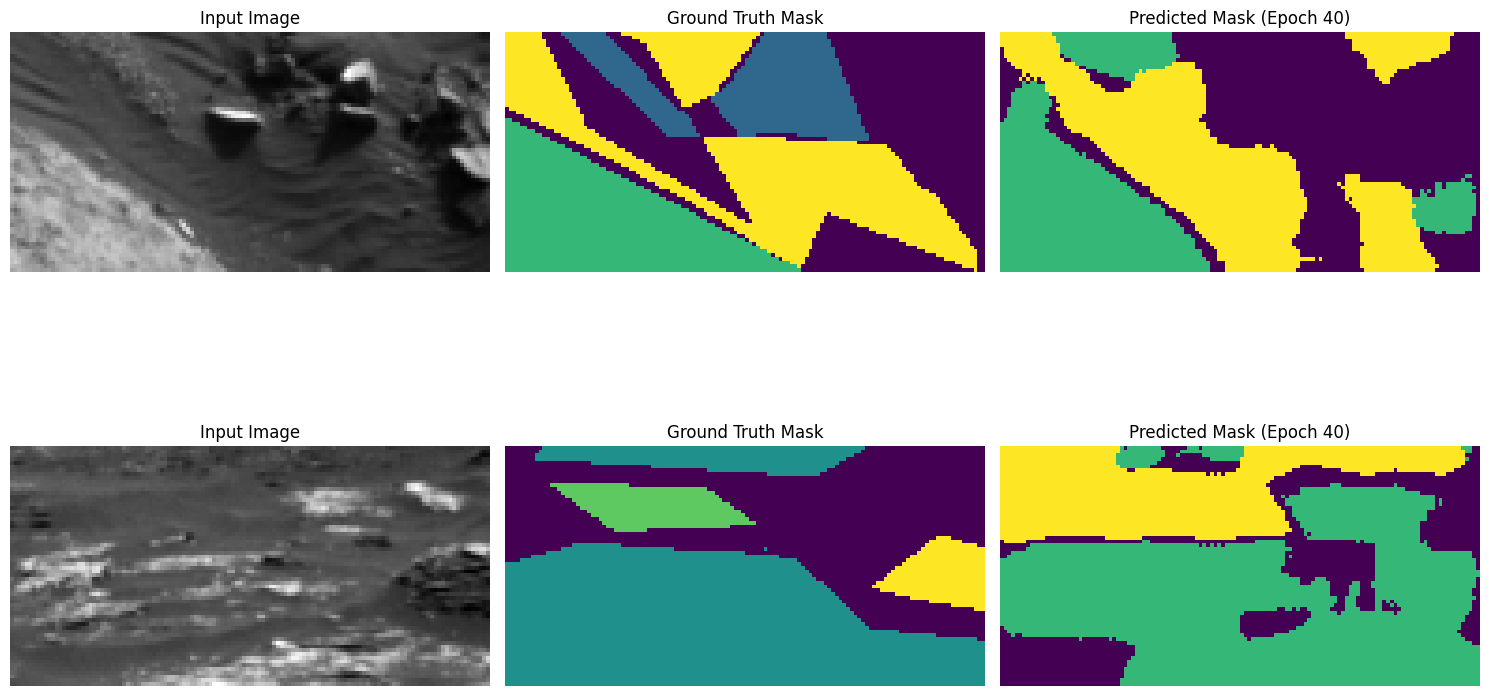

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.8754 - loss: 0.3261 - mean_io_u: 0.5741 - val_accuracy: 0.7697 - val_loss: 0.7050 - val_mean_io_u: 0.4728 - learning_rate: 6.2500e-06
Epoch 41/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8768 - loss: 0.3227 - mean_io_u: 0.5751
Epoch 41: val_loss did not improve from 0.66434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


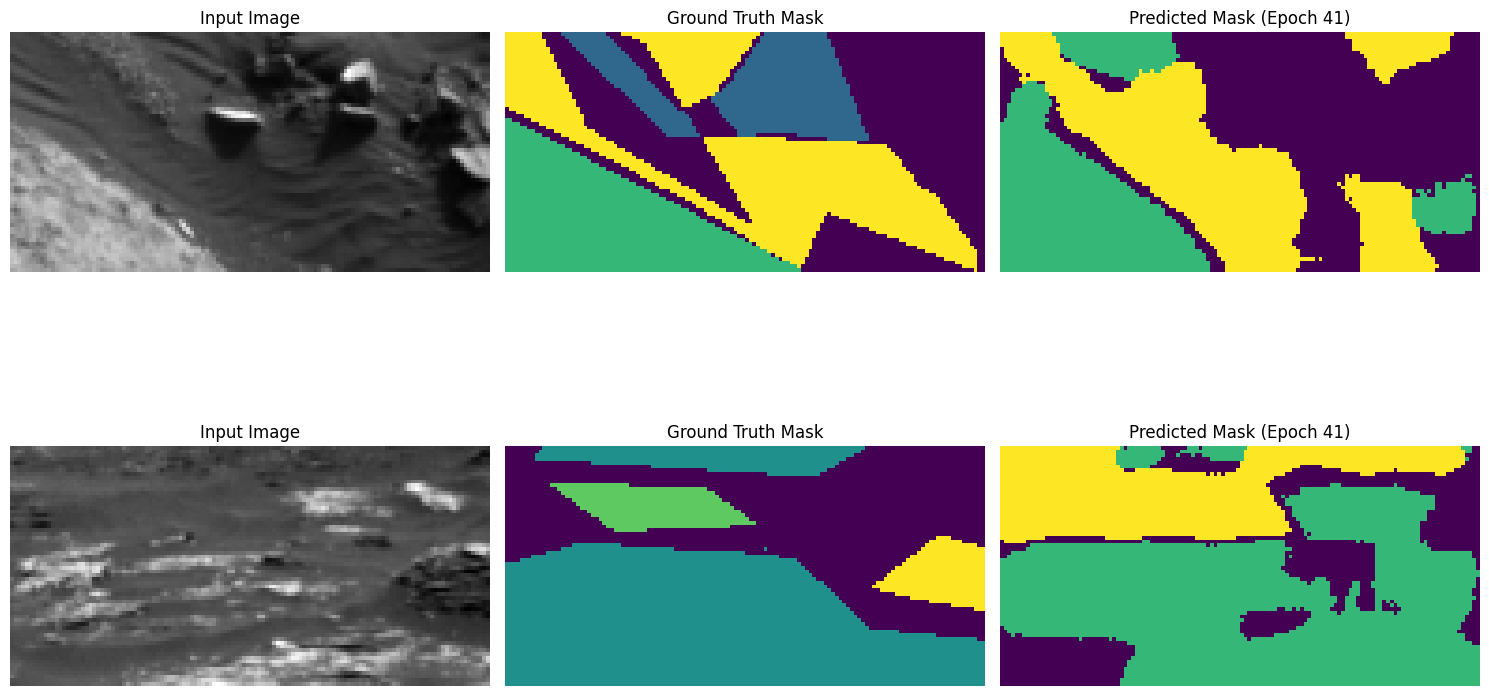

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 209ms/step - accuracy: 0.8769 - loss: 0.3227 - mean_io_u: 0.5751 - val_accuracy: 0.7697 - val_loss: 0.7077 - val_mean_io_u: 0.4728 - learning_rate: 6.2500e-06
Epoch 42/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8782 - loss: 0.3195 - mean_io_u: 0.5760
Epoch 42: val_loss did not improve from 0.66434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


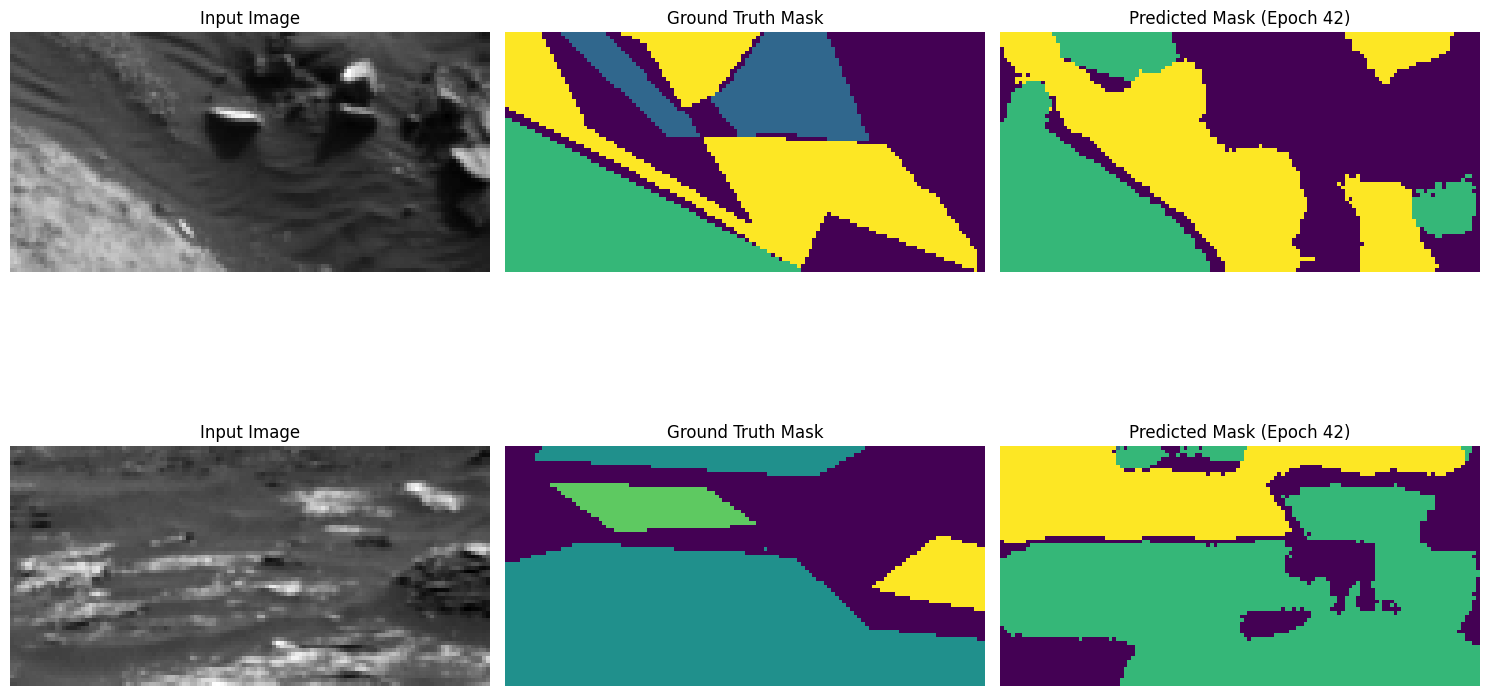

251/251 ━━━━━━━━━━━━━━━━━━━━ 52s 209ms/step - accuracy: 0.8782 - loss: 0.3194 - mean_io_u: 0.5760 - val_accuracy: 0.7697 - val_loss: 0.7107 - val_mean_io_u: 0.4729 - learning_rate: 6.2500e-06
Epoch 43/1000
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8795 - loss: 0.3165 - mean_io_u: 0.5768
Epoch 43: val_loss did not improve from 0.66434

Epoch 43: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


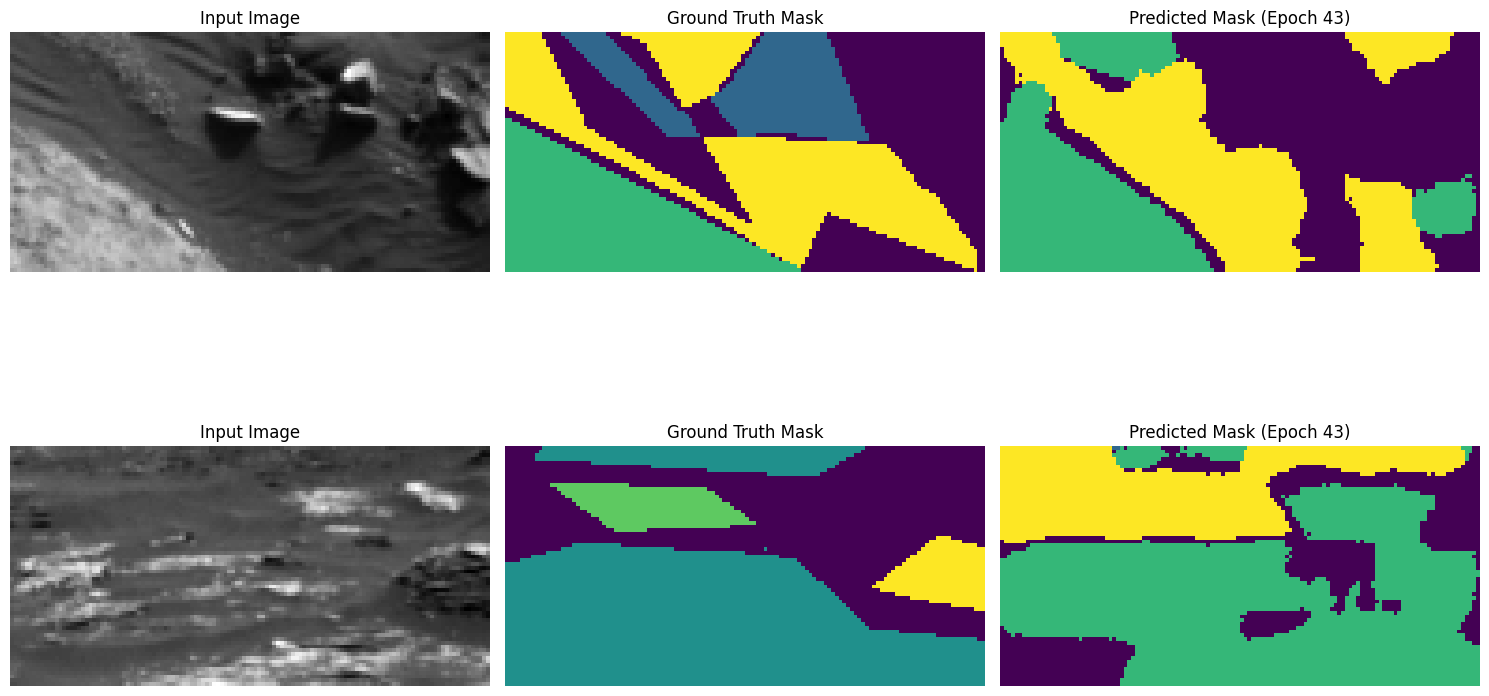

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.8795 - loss: 0.3164 - mean_io_u: 0.5768 - val_accuracy: 0.7697 - val_loss: 0.7136 - val_mean_io_u: 0.4729 - learning_rate: 6.2500e-06


In [18]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl

# Residual Block
def residual_block(x, filters):
    shortcut = x
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    shortcut = tfkl.Conv2D(filters, (1, 1), padding='same')(shortcut)
    return tfkl.add([x, shortcut])

# Dice Loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return tf.reduce_mean(1 - numerator / (denominator + tf.keras.backend.epsilon()))

# Hybrid Loss Function
def combined_loss(weights):
    ce_loss = weighted_categorical_crossentropy(weights)
    def loss(y_true, y_pred):
        return ce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# U-Net with Residual Connections
def unet_with_residual_blocks(input_shape, num_classes):
    inputs = tfkl.Input(input_shape)

    # Encoder
    c1 = residual_block(inputs, 64)
    p1 = tfkl.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = tfkl.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256)
    p3 = tfkl.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 512)

    # Decoder
    u1 = tfkl.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = tfkl.concatenate([u1, c3])
    d1 = residual_block(u1, 256)

    u2 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d1)
    u2 = tfkl.concatenate([u2, c2])
    d2 = residual_block(u2, 128)

    u3 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d2)
    u3 = tfkl.concatenate([u3, c1])
    d3 = residual_block(u3, 64)

    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(d3)

    return tf.keras.Model(inputs, outputs)

# Initialize the model
input_shape = X_train.shape[1:]
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

model = unet_with_residual_blocks(input_shape, num_classes)
# Define the optimizer with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy", mean_iou])

model.summary()

# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  # Add validation data
    #batch_size=32,
    epochs=1000,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, visualize_callback]
)

# Save the model
model.save("best_model_resunet.keras")


In [19]:
model_filename = f"model_augmented_hvr_best_batch8.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_augmented_hvr_best_batch8.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [20]:
import os
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [21]:
print(f"X_test shape before reshaping: {X_test.shape}")

X_test shape before reshaping: (10022, 64, 128, 1)


In [22]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step
Predictions shape: (10022, 64, 128)


Randomly selected indices for prediction (seed=42): [3543 5731 4801  416 5125 9915  293 5020 1765 4192 2288 1188  107 7583
  856 5090 9784 5192 6935  850]


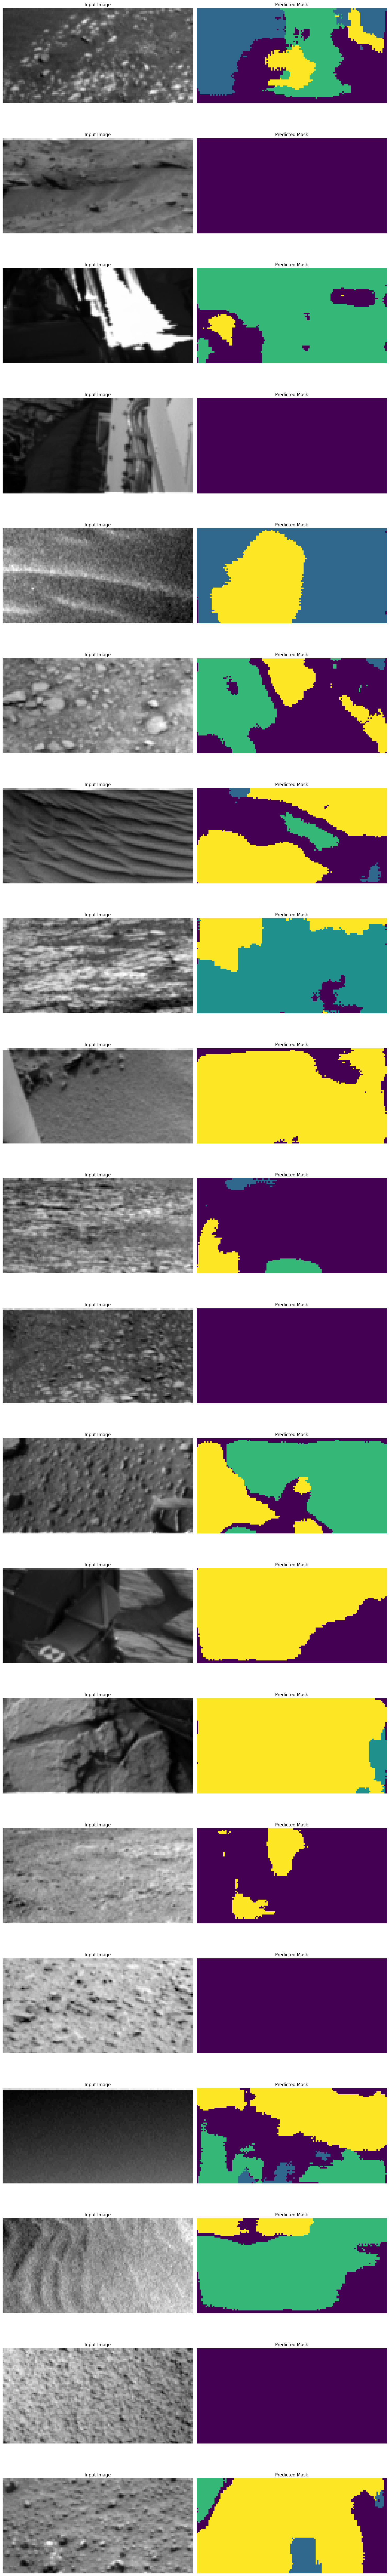

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
# Randomly select 20 indices for prediction
random_indices = np.random.choice(X_test.shape[0], size=20, replace=False)
print(f"Randomly selected indices for prediction (seed=42): {random_indices}")

# Select 20 random samples and their corresponding masks
X_sample = X_test[random_indices]



predicted_masks = preds

# Visualize the predictions
num_images = len(X_sample)  # Number of images to visualize
fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

for i in range(num_images):
    # Original Image
    ax_img = axes[i, 0]
    ax_img.imshow(X_sample[i].squeeze(), cmap="gray")
    ax_img.set_title("Input Image")
    ax_img.axis("off")

    # Predicted Mask
    ax_pred = axes[i, 1]
    ax_pred.imshow(predicted_masks[i], cmap="viridis")
    ax_pred.set_title("Predicted Mask")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()

In [24]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [25]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)



In [26]:
len(submission_df.columns)

8193

In [27]:
len(submission_df)

10022